# Imports

In [4]:
# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate



# Local imports
import toy_models.xornet
import toy_models.tms
import toy_models.train
import toy_models.transformer_wrapper
import eigenestimation_algorithm.train
import eigenestimation_algorithm.eigenestimation
import eigenestimation_algorithm.evaluation

# Reload modules for interactive sessions
importlib.reload(toy_models.xornet)
importlib.reload(toy_models.tms)
importlib.reload(toy_models.train)
importlib.reload(toy_models.transformer_wrapper)
importlib.reload(eigenestimation_algorithm.train)
importlib.reload(eigenestimation_algorithm.eigenestimation)
importlib.reload(eigenestimation_algorithm.evaluation)

# Specific imports from local modules
from toy_models.xornet import XORNet, GenerateXORData, XORNetParallel, GenerateXORDataParallel
from toy_models.tms import Autoencoder, AutoencoderSymmetric, GenerateTMSData, AutoencoderParallel, GenerateTMSDataParallel
from toy_models.train import TrainModel
from toy_models.transformer_wrapper import TransformerWrapper, DeleteParams, KLDivergenceLoss
from eigenestimation_algorithm.eigenestimation import EigenEstimation, EigenEstimationComparison
from eigenestimation_algorithm.train import TrainEigenEstimation, TrainEigenEstimationComparison
from eigenestimation_algorithm.evaluation import (
    PrintFeatureVals,
    ActivatingExamples,
    PrintFeatureValsTransformer,
    PrintActivatingExamplesTransformer,
    DrawNeuralNetwork
)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'


import eigenestimation_algorithm.gradientextractor
importlib.reload(eigenestimation_algorithm.gradientextractor)

from eigenestimation_algorithm.gradientextractor import (
    JacobianExtractor,
    ExtractJacs,
) 


# TMS

Setup toy models, generate/pull data, and train.

## Single TMS

In [5]:
#@title Train TMS
n_features = 5
hidden_dim = 2
n_datapoints = 5000
sparsity = .05

batch_size = 16
learning_rate = .01
n_epochs = 500
torch.manual_seed(42)

X_tms, Y_tms, dataloader_TMS = GenerateTMSData(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size)
tms_model = AutoencoderSymmetric(n_features, hidden_dim).to(device)
_, _, _ = TrainModel(tms_model, nn.MSELoss(), learning_rate, dataloader_TMS, n_epochs=n_epochs, device=device)

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()


Epoch 250, Loss: 0.022324837744235992
Epoch 300, Loss: 0.0038242863956838846
Epoch 350, Loss: 0.0029071609023958445


## Parallel TMS

Set up parallel TMS

In [7]:
torch.manual_seed(42)
n_networks = 3
n_features = 5

n_datapoints = 3*4096
X_tms_p, Y_tms_p, dataloader_tms_p = GenerateTMSDataParallel(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size, n_networks=n_networks)
tms_model_p = AutoencoderParallel(n_features, hidden_dim, n_networks).to(device)


for n,p in tms_model.named_parameters():
    if "W" in n:
        dict(tms_model_p.named_parameters())['W_in'].data = torch.block_diag(*[p for _ in range(n_networks)])
        dict(tms_model_p.named_parameters())['W_out'].data = torch.block_diag(*[p.transpose(0,1) for _ in range(n_networks)])

    if "b" in n:
        dict(tms_model_p.named_parameters())[n].data = torch.concat([p for _ in range(n_networks)])


params_to_delete = [name for name, param in tms_model_p.named_parameters() if "W" not in name]

DeleteParams(tms_model_p, params_to_delete)

print(dict(tms_model_p.named_parameters()))

(12288, 15)
(12288,)
{'W_in': Parameter containing:
tensor([[ 0.9562,  0.6134,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2781,  1.1116,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.1427,  0.0854,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.4354, -1.0729,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8831, -0.7311,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.9562,  0.6134,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2781,  1.1116,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.1427,  0.0854,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.4354, -1.0729,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.8831, -0.7311,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9562,  0.6134],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.2781,  1.1116],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.1427,  0.0854],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.4354, -1.0729],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.8831

In [28]:
#@title Eigenestimation.py

import torch
import torch.nn as nn
from torch.nn.utils import stateless
from torch.func import jacrev, functional_call, jvp, vmap, jacrev
import einops
from typing import Any, Dict, List, Tuple, Callable
import gc
from functools import partial 
from torch.autograd.functional import jacobian
import einops
import torch
from torch import nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from typing import Any, List
import einops
import gc
import math
import time 
from torch import Tensor

def HoraShape(tensor, n_dim, n_features):
    return einops.repeat(
        einops.einsum(
            tensor, 'h w ... -> h ...'), 'h ... -> h d ... r', r=n_features, d=n_dim).shape

class EigenHora(nn.Module):
    def __init__(self, 
    model: nn.Module, 
    model0: Callable,
    loss: Callable, 
    n_features: int,
    reduced_dim: int =1,
    device='cuda') -> None:
        super(EigenHora, self).__init__()

        self.model: nn.Module = model
        self.model0: Callable = model0
        self.loss: Callable = loss
        self.param_dict = {name: param.detach().clone() for name, param in model.named_parameters()}
        self.n_params = sum([v.numel() for v in self.param_dict.values()])
        self.u_left = {name:  
            (torch.randn(HoraShape(param, reduced_dim, n_features))
             ).to(device).requires_grad_(True) for name, param in self.model.named_parameters()}
        self.u_right = {name:  
            (torch.randn(HoraShape(param.transpose(0,1), reduced_dim, n_features))/n_features
             ).to(device).requires_grad_(True) for name, param in self.model.named_parameters()}
        



    def compute_loss(
        self, x: torch.Tensor, param_dict
    ) -> torch.Tensor:
        # Perform a stateless functional call to the model with given parameters
        #param_dict = self.vector_to_parameters(parameters)
        outputs: torch.Tensor = functional_call(self.model, param_dict, (x,))
       
        # Detach outputs to prevent gradients flowing back
        with torch.no_grad():
            truth: torch.Tensor = self.model0(x)
            
        # Compute the loss without reduction
        return einops.einsum(self.loss(outputs, truth), 's ... -> s')#.squeeze(0)

    def compute_jacobian(self, x:torch.Tensor):
        return torch.func.jacrev(self.compute_loss, argnums=-1)(x, self.param_dict)
    
    def forward(self, jacobian: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        #3print(jacobian['W_in'].shape)
        #print(self.u_right['W_in'].shape)
        jac_left = {name:einops.einsum(jacobian[name], self.u_left[name], 's h w ... , h d ... f -> s ... d w f') for name in jacobian}
        jvp_dict = {name:einops.einsum(jac_left[name], self.u_right[name], 's ... d w f, w d ... f -> s ... f') for name in jac_left}
        jvp = einops.einsum(torch.stack([jvp_dict[name] for name in jvp_dict], dim=0).sum(dim=0), 's ... f -> s f')
        return jvp
    
    
    def reconstruct(self, jvp: torch.Tensor)-> torch.Tensor:
        reconstruction_left = {name:einops.einsum(jvp, self.u_left[name], 's f, h d ... f ->  s h d  ... f') for name in self.u_left}
        reconstruction = {name:einops.einsum(reconstruction_left[name], self.u_right[name], 's h d ... f, w d ... f -> s ... h w') for name in reconstruction_left}
        return reconstruction
    
    
eps = 1e-10
def Train(
    eigenmodel: nn.Module,
    jacobian_dataloader: DataLoader,
    lr: float,
    n_epochs: int,
    L0_penalty: float,
    device: str = 'cuda'
) -> None:

    # Collect parameters to optimize (excluding the model's own parameters)
    params_to_optimize = [*[eigenmodel.u_left[name] for name in eigenmodel.u_left], *[eigenmodel.u_right[name] for name in eigenmodel.u_right]]
    optimizer: Optimizer = torch.optim.Adam(params_to_optimize, lr=lr)
    
    for epoch in range(n_epochs):
        sparsity_losses: float = 0.0
        reconstruction_losses: float = 0.0
        total_losses: float = 0.0
        n_batches: int = 0
        for jacobian in jacobian_dataloader:
            n_batches = n_batches + 1
            jvp = eigenmodel(jacobian)
            reconstruction = eigenmodel.reconstruct(jvp.relu())
            L2_error = torch.stack([einops.einsum(
                (reconstruction[name] - jacobian[name])**2, 's ... h w -> s') for name in jacobian]).mean()
            L0_error = einops.einsum((abs(jvp)+ eps), 's ... f -> s').mean()
            L = L2_error + L0_penalty * L0_error
            
            sparsity_losses = sparsity_losses + L0_error
            reconstruction_losses = reconstruction_losses + L2_error
            total_losses = total_losses + L
        
            L.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Logging progress every 1% of total epochs
        if epoch % max(1, round(n_epochs / 100)) == 0:
            avg_total_loss =total_losses / n_batches
            avg_sparsity_loss = sparsity_losses / n_batches
            avg_reconstruction_loss = reconstruction_losses / n_batches
            print(
                f'Epoch {epoch} : {avg_total_loss:.3f},  '
                f'Reconstruction Loss: {avg_reconstruction_loss:.3f},  '
                f'Sparsity Loss: {avg_sparsity_loss:.3f}'
                )
            
            
from torch.utils.data import DataLoader

class TransformDataLoader:
    def __init__(self, data, transform_fn, batch_size):
        self.dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
        self.transform_fn = transform_fn

    def __iter__(self):
        for batch in self.dataloader:
            yield self.transform_fn(batch)

    def __len__(self):
        return len(self.dataloader)
    
    
def model0(x):
    with torch.no_grad():
        return 0*tms_model_p(x)
    
def MSELoss(x, y):
    return (x-y)**2


eigenmodel = EigenHora(tms_model_p, model0, MSELoss, 15, 1, device=device)
dataloader = TransformDataLoader(X_tms_p.to(device), batch_size=32, transform_fn=eigenmodel.compute_jacobian)
Train(eigenmodel, dataloader, lr=.01, n_epochs=20, L0_penalty=.1, device="cuda")

Epoch 0 : 1.469,  Reconstruction Loss: 1.324,  Sparsity Loss: 1.447
Epoch 1 : 1.009,  Reconstruction Loss: 0.858,  Sparsity Loss: 1.514
Epoch 2 : 0.918,  Reconstruction Loss: 0.768,  Sparsity Loss: 1.498
Epoch 3 : 0.891,  Reconstruction Loss: 0.744,  Sparsity Loss: 1.470
Epoch 4 : 0.881,  Reconstruction Loss: 0.735,  Sparsity Loss: 1.454
Epoch 5 : 0.880,  Reconstruction Loss: 0.737,  Sparsity Loss: 1.437
Epoch 6 : 0.881,  Reconstruction Loss: 0.737,  Sparsity Loss: 1.436
Epoch 7 : 0.871,  Reconstruction Loss: 0.729,  Sparsity Loss: 1.419
Epoch 8 : 0.867,  Reconstruction Loss: 0.725,  Sparsity Loss: 1.414
Epoch 9 : 0.867,  Reconstruction Loss: 0.725,  Sparsity Loss: 1.420
Epoch 10 : 0.869,  Reconstruction Loss: 0.729,  Sparsity Loss: 1.405
Epoch 11 : 0.864,  Reconstruction Loss: 0.722,  Sparsity Loss: 1.416
Epoch 12 : 0.860,  Reconstruction Loss: 0.718,  Sparsity Loss: 1.419
Epoch 13 : 0.875,  Reconstruction Loss: 0.733,  Sparsity Loss: 1.419
Epoch 14 : 0.867,  Reconstruction Loss: 0.72

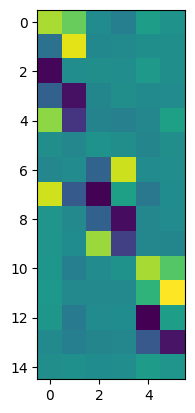

In [31]:
a = einops.einsum(eigenmodel.u_left['W_in'], eigenmodel.u_right['W_in'], 'h r f, w r f -> h w')
plt.imshow(a.detach().cpu().numpy())

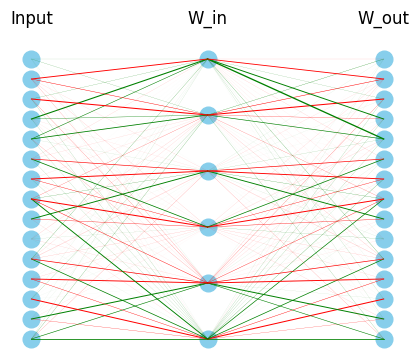

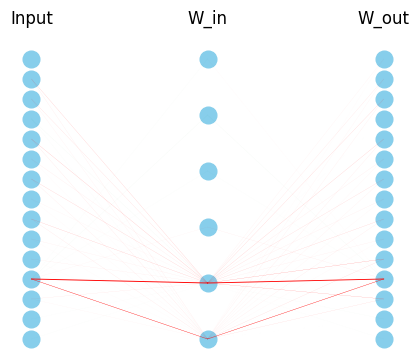

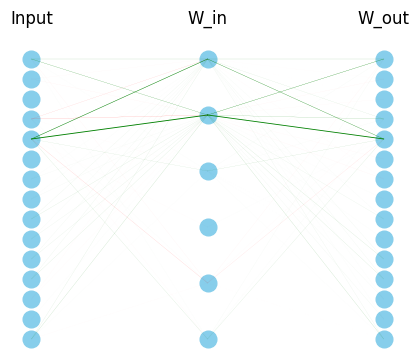

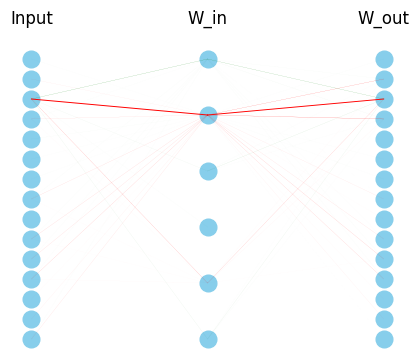

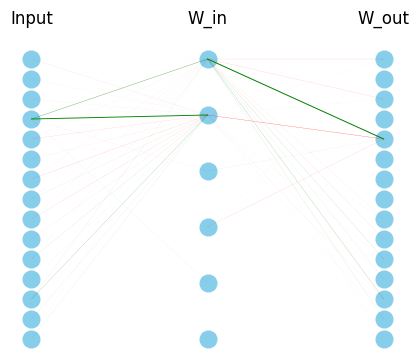

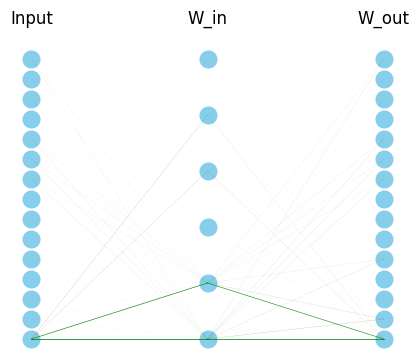

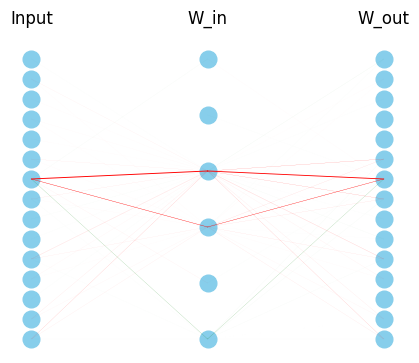

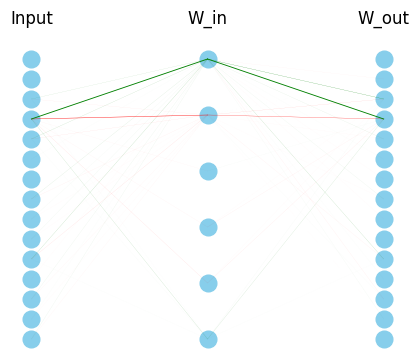

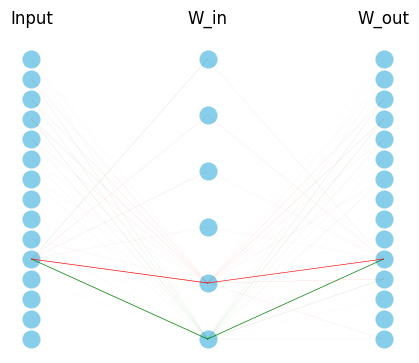

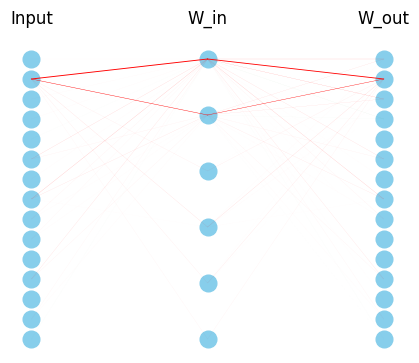

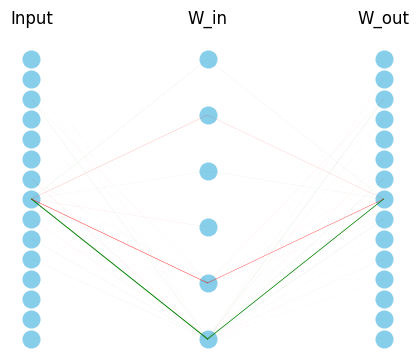

In [30]:
DrawNeuralNetwork({name:
    einops.einsum(eigenmodel.u_left[name], eigenmodel.u_right[name], 'w r f, h r f -> w h').transpose(0,1) for name in eigenmodel.u_right})
for i in range(10):
    DrawNeuralNetwork({name:
    einops.einsum(eigenmodel.u_left[name], eigenmodel.u_right[name], 'w r f, h r f -> w h f')[:,:,i].transpose(0,1) for name in eigenmodel.u_right}
)

In [33]:
max_vals = []
for i in range(n_features):
    test = torch.zeros_like(f_eye)
    test[i] = 1
    a = HoraDict(hora1_dict, hora2_dict, test)
    max_vals = max_vals + [abs(a['W_in']).sum(dim=-1).argmax().item()]
    
DrawNeuralNetwork(param_dict)
DrawNeuralNetwork(HoraDict(hora1_dict, hora2_dict, f_eye+1))

for i in range(n_features):
    test = torch.zeros_like(f_eye)
    test[i] = 1*n_features
    a = HoraDict(hora1_dict, hora2_dict, test)
    DrawNeuralNetwork(a)

NameError: name 'f_eye' is not defined

In [892]:
def compute_loss_with_param_dict(x: torch.Tensor, model, model0, dict_to_add, eye, coeff):
    new_param_dict = AddedDict(param_dict, dict_to_add, coeff=coeff)
    new_outputs = functional_call(model, new_param_dict, (x,))


    with torch.no_grad():
        truth = model0(x)
        old_outputs = model(x)
    loss_with_lora = ((new_outputs - truth)**2).sum(dim=-1)
    #original_loss = ((old_outputs - truth)**2).sum(dim=-1)
    return loss_with_lora #/ original_loss

partial_func = partial(compute_loss_from_hora_dicts, X, tms_model_p,model0, hora1_dict, hora2_dict, f_eye+1)
j_reconstruct = jacrev(partial_func)(f_zero)
print(abs(j_reconstruct).mean())
a = dict()
a['W_in'] = -param_dict['W_in']
a['W_out'] = -param_dict['W_out']
partial_func = partial(compute_loss_with_param_dict, X, tms_model_p,model0,a, f_eye+1)
j_reconstruct = jacrev(partial_func)(f_zero)
print(abs(j_reconstruct).mean())

tensor(0.8391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0481, device='cuda:0', grad_fn=<MeanBackward0>)


In [890]:
abs(j_reconstruct).mean()

tensor(2.0481, device='cuda:0', grad_fn=<MeanBackward0>)

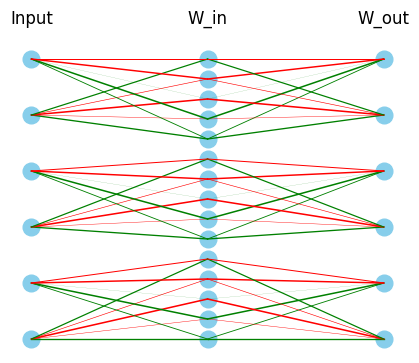

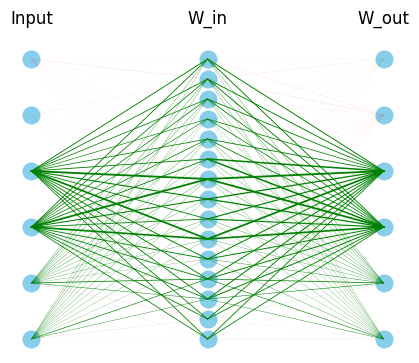

In [747]:
DrawNeuralNetwork(param_dict)
DrawNeuralNetwork(HoraDict(hora1_dict, hora2_dict, 1*torch.ones_like(f_eye)))

In [653]:
from functools import partial 
from torch.func import jacrev
eps = 1e-10

n_epochs = 30

reduced_dim = 5
n_features = 20

param_dict = {name: param.detach().clone() for name, param in model.named_parameters()}
hora1_dict = {name: torch.randn(HoraShape(param, reduced_dim, n_features)).to(device).requires_grad_(True) for name, param in model.named_parameters()}

hora2_dict = {name: torch.randn(HoraShape(param.transpose(0,1), reduced_dim, n_features)).to(device).requires_grad_(True) for name, param in model.named_parameters()}


f_eye = torch.zeros(n_features).to(device).requires_grad_(True)
f_zero = torch.Tensor([0.]).requires_grad_(True).to(device)

params_to_optimize = [hora1_dict['W_in'], hora2_dict['W_in']]
optimizer = torch.optim.Adam(params_to_optimize, lr=.01)
def model0(x):
    return 0

eps = 1e-10
for epoch in range(n_epochs):
    total_loss = 0
    batch = 0
    total_individual_loss = 0
    total_reconstruct_loss = 0
    n_samples = 0
    for X in DataLoader(X_tms_p, batch_size=16, shuffle=True):
        n_samples = n_samples + X.shape[0]
        with torch.no_grad():
            norm1 = ParamDictNorm(HoraDict(hora1_dict, hora2_dict, f_eye+1))
            norm2 = ParamDictNorm(param_dict)
            norm = norm1/norm2

#ParamDictNorm(HoraDict(hora1_dict, hora2_dict, f_eye + 1))#/n_features
            #norm1 = (sum([(hora1_dict[name]**2).sum() for name in hora1_dict])+eps)**.5
            #norm2 = (sum([(hora2_dict[name]**2).sum() for name in hora1_dict])+eps)**.5

            for i,name in enumerate(hora1_dict):
                hora1_dict[name].div_((norm+eps)**.5)
                hora2_dict[name].div_((norm+eps)**.5)
            
        optimizer.zero_grad()
        batch= batch + 1

        partial_func = partial(compute_loss_with_hora, X, tms_model_p,model0, hora1_dict, hora2_dict)
        j_individual = jacrev(partial_func)(f_eye)#, '... f, f -> ... f')

        partial_func = partial(compute_loss_from_hora_dicts, X, tms_model_p,model0, hora1_dict, hora2_dict, f_eye+1)
        j_reconstruct = jacrev(partial_func)(f_zero)

        #loss_individual = ((abs(j_individual)+eps)**.5).mean()#dim=-1).mean() #+eps)**.3).sum(dim=-1).mean()
        j_jt = einops.einsum(j_individual, j_individual, '... f1, ... f2 ->  f1 f2 ...')
        j_jt_relu = einops.einsum((-j_individual).relu(), (-j_individual).relu(), '... f1, ... f2 ->  f1 f2 ...')

        lower_triangular_mask: torch.Tensor = torch.tril(
              torch.ones(j_jt.shape[0],j_jt.shape[0], dtype=torch.bool), diagonal=-1
        ).to(device)
        diag_mask: torch.Tensor = torch.eye(j_jt.shape[0], dtype=torch.bool).to(device)
        not_diag_mask: torch.Tensor = (1.0-torch.eye(j_jt.shape[0], dtype=torch.float)).bool().to(device)
       
        loss_individual = ((abs(j_individual)+eps)**.5).sum(dim=-1).mean() #((abs(j_jt[lower_triangular_mask,...]))).sum(dim=0).mean()#(dim=0).mean()#(dim=0).mean()#(dim=-1).mean()#dim=-1).mean() #+eps)**.3).sum(dim=-1).mean()
        loss_reconstruct =  j_reconstruct.mean() #(j_jt_relu[diag_mask,...]).mean()#(dim=0).mean()#(dim=-1).mean() # We want the jacoboian to go very negative. 
        
        #loss_individual = ((abs(j_jt[not_diag_mask,...]))).mean()#(dim=0).mean() #((abs(j_jt[lower_triangular_mask,...]))).sum(dim=0).mean()#(dim=0).mean()#(dim=0).mean()#(dim=-1).mean()#dim=-1).mean() #+eps)**.3).sum(dim=-1).mean()
        #loss_reconstruct =  (j_jt_relu[diag_mask,...]).mean() #(j_jt_relu[diag_mask,...]).mean()#(dim=0).mean()#(dim=-1).mean() # We want the jacoboian to go very negative. 

        #L1 = HoraDictL1(hora1_dict, hora2_dict)
        loss =  -loss_reconstruct #+ .1*L1 #+ loss_individual #+ loss_individual # #+ 10*L1# 0*jac_loss #+ .01*L1 #- jac_loss #/X.shape[0](abs(j_j[not_diag,...]) + eps)**.1).mean()#/X.shape[0]#j_j[not_diag,...])).sum()
        
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss
        total_individual_loss = total_individual_loss + loss_individual
        total_reconstruct_loss = total_reconstruct_loss + loss_reconstruct

    print(epoch, (total_loss/batch).item(), 'total_loss', (total_loss/batch).item(),
    'individual', (total_individual_loss/batch).item(), 'reconstruction', (total_reconstruct_loss/batch).item())
    #print(max([(((hora1_dict['W_in'][:,:,i] @ hora2_dict['W_in'][:,:,i].transpose(0,1))**2).sum()**.5).item() for i in range(n_features)]))
    #DrawNeuralNetwork(HoraDict(hora1_dict, hora2_dict, 1*torch.ones_like(f_eye)))
    #max_vals = []
    #for i in range(n_features):
    #    test = torch.zeros_like(f_eye)
    #    test[i] = 1
    #    a = HoraDict(hora1_dict, hora2_dict, test)
    #    max_vals = max_vals + [abs(a['W_in']).sum(dim=-1).argmax().item()]
    #DrawNeuralNetwork(a)
print(set(max_vals))
print(hora1_dict['W_in'][:2,:2])


KeyboardInterrupt: 

In [815]:
for i in range(15):
    print(i, ((hora1_dict['W_in'][:,:,i] @ hora2_dict['W_in'][:,:,i].transpose(0,1))**2).sum())

0 tensor(2.6186e-08, device='cuda:0', grad_fn=<SumBackward0>)
1 tensor(17.6104, device='cuda:0', grad_fn=<SumBackward0>)
2 tensor(8.7238e-08, device='cuda:0', grad_fn=<SumBackward0>)
3 tensor(2.3845e-09, device='cuda:0', grad_fn=<SumBackward0>)
4 tensor(1.5001e-08, device='cuda:0', grad_fn=<SumBackward0>)
5 tensor(1.8046e-08, device='cuda:0', grad_fn=<SumBackward0>)
6 tensor(2.2086e-09, device='cuda:0', grad_fn=<SumBackward0>)
7 tensor(2.4679e-08, device='cuda:0', grad_fn=<SumBackward0>)
8 tensor(8.9990e-09, device='cuda:0', grad_fn=<SumBackward0>)
9 tensor(1.2974e-08, device='cuda:0', grad_fn=<SumBackward0>)
10 tensor(9.0715e-09, device='cuda:0', grad_fn=<SumBackward0>)
11 tensor(1.3894e-08, device='cuda:0', grad_fn=<SumBackward0>)
12 tensor(1.2276e-08, device='cuda:0', grad_fn=<SumBackward0>)
13 tensor(7.9539e-09, device='cuda:0', grad_fn=<SumBackward0>)
14 tensor(1.7866e-08, device='cuda:0', grad_fn=<SumBackward0>)


{0, 2, 6, 7, 8, 9, 11, 12, 14}


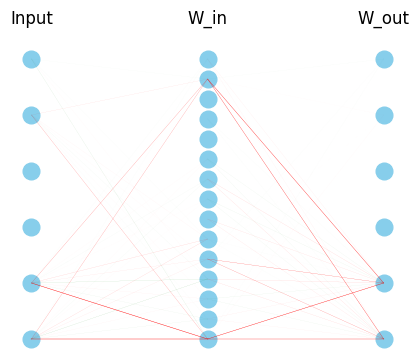

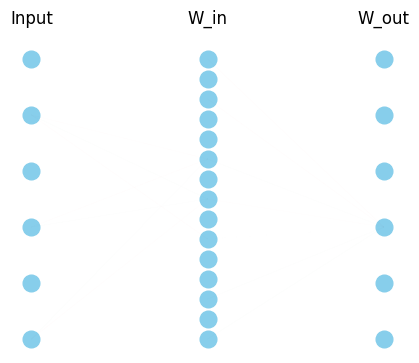

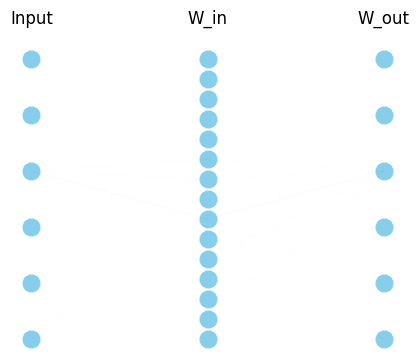

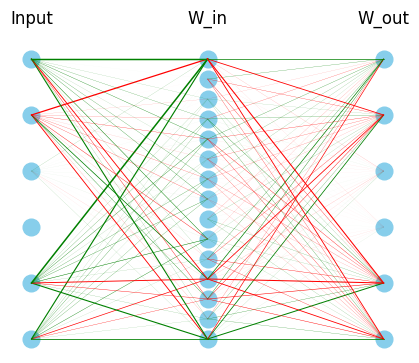

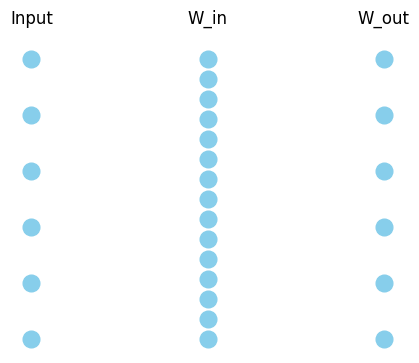

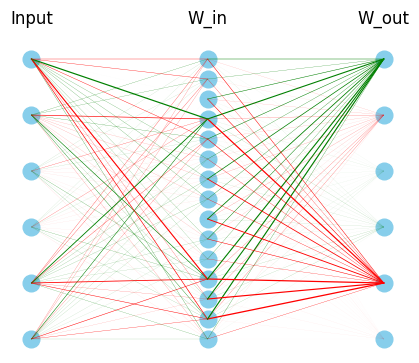

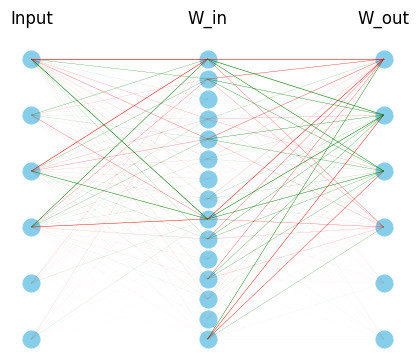

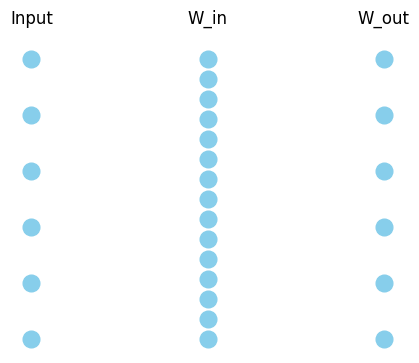

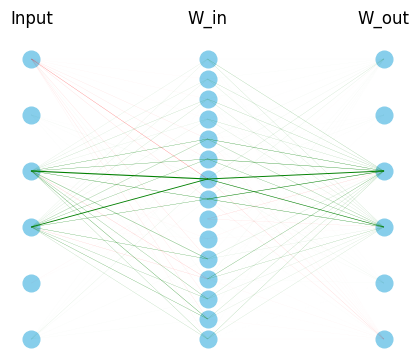

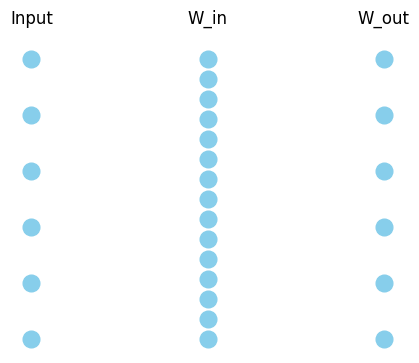

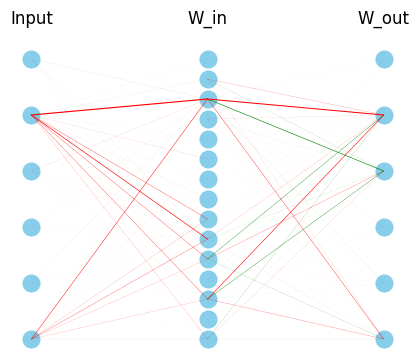

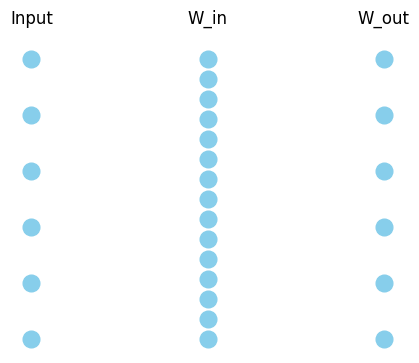

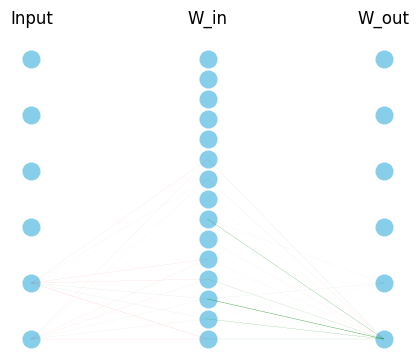

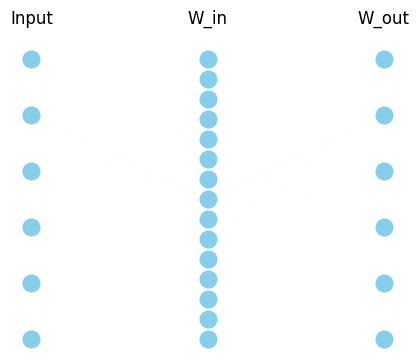

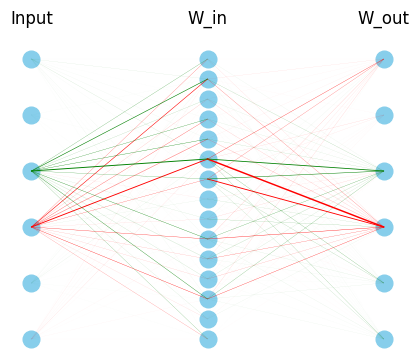

In [268]:
for i in range(15):
    print(j_jt_relu[7,7,:])

tensor([0.0000e+00, 2.5510e-04, 0.0000e+00, 1.2610e-08, 2.1220e-07, 1.0789e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7188e-03, 0.0000e+00, 1.0338e-10,
        1.1433e-01, 8.5663e-07, 1.6327e-07, 2.8933e-08], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([0.0000e+00, 2.5510e-04, 0.0000e+00, 1.2610e-08, 2.1220e-07, 1.0789e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7188e-03, 0.0000e+00, 1.0338e-10,
        1.1433e-01, 8.5663e-07, 1.6327e-07, 2.8933e-08], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([0.0000e+00, 2.5510e-04, 0.0000e+00, 1.2610e-08, 2.1220e-07, 1.0789e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7188e-03, 0.0000e+00, 1.0338e-10,
        1.1433e-01, 8.5663e-07, 1.6327e-07, 2.8933e-08], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([0.0000e+00, 2.5510e-04, 0.0000e+00, 1.2610e-08, 2.1220e-07, 1.0789e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7188e-03, 0.0000e+00, 1.0338e-10,
        1.1433e-01, 8.5663e-07, 1.6327e

In [97]:
j_individual

tensor([[ 1.9503e-06,  3.3039e-05,  6.1124e-07, -7.7665e-08,  2.5036e-02,
         -1.0533e-05,  6.4054e-05, -2.9815e-07,  3.4723e-04,  1.4485e-06,
         -6.9691e-04, -8.1852e-01, -3.9181e-07, -4.1234e-06, -1.1353e+00],
        [-1.0050e-03,  1.8193e-03, -2.0033e+00, -3.6760e-04, -5.2578e-05,
         -2.2771e+00,  1.1430e-04, -2.6993e-04,  7.8658e-08,  8.9745e-04,
         -6.5465e-06, -1.5865e-05, -2.2768e+00, -2.2651e+00, -1.4983e-05],
        [ 3.4820e-05,  1.9613e-04, -7.3316e-06, -3.1179e+00,  3.7516e-04,
         -1.6531e-06, -2.0739e+00, -5.9888e-03, -1.3808e+00,  1.5619e-02,
         -7.9759e-03,  6.1643e-03,  3.7473e-05,  7.4996e-05, -2.8421e-03],
        [ 5.7062e-06,  5.8370e-05, -1.0126e-06, -7.4394e-01, -1.5753e-05,
         -3.7800e-06, -5.0891e-01,  8.1621e-03, -1.0087e-07,  2.6913e-04,
         -8.6400e-07, -7.5063e-07,  5.0917e-06,  3.1862e-07,  7.6358e-06],
        [ 6.3081e-06,  7.7710e-05,  1.2244e-06,  2.3520e-06,  5.9283e-02,
         -2.2367e-05,  1.6210e-04,

In [102]:
for i in range(5):
    print(f'-----{i}-----')
    print(X[j_individual[:,i].argsort(descending=False),:][:3])

-----0-----
tensor([[0.5456, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6814, 0.0000, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.9398, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')
-----1-----
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.7447, 0.0000, 0.0000, 0.0000, 0.0000,
         0.9101, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5828, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4523, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')
-----2-----
tensor([[0.0000, 0.0000, 0.6814, 0.0000, 0.0000, 0.0000, 0.2400, 0.0000, 0.0000,
         0.00

In [68]:
j_individual

tensor([[ 1.9503e-06,  3.3039e-05,  6.1124e-07, -7.7665e-08,  2.5036e-02,
         -1.0533e-05,  6.4054e-05, -2.9815e-07,  3.4723e-04,  1.4485e-06,
         -6.9691e-04, -8.1852e-01, -3.9181e-07, -4.1234e-06, -1.1353e+00],
        [-1.0050e-03,  1.8193e-03, -2.0033e+00, -3.6760e-04, -5.2578e-05,
         -2.2771e+00,  1.1430e-04, -2.6993e-04,  7.8658e-08,  8.9745e-04,
         -6.5465e-06, -1.5865e-05, -2.2768e+00, -2.2651e+00, -1.4983e-05],
        [ 3.4820e-05,  1.9613e-04, -7.3316e-06, -3.1179e+00,  3.7516e-04,
         -1.6531e-06, -2.0739e+00, -5.9888e-03, -1.3808e+00,  1.5619e-02,
         -7.9759e-03,  6.1643e-03,  3.7473e-05,  7.4996e-05, -2.8421e-03],
        [ 5.7062e-06,  5.8370e-05, -1.0126e-06, -7.4394e-01, -1.5753e-05,
         -3.7800e-06, -5.0891e-01,  8.1621e-03, -1.0087e-07,  2.6913e-04,
         -8.6400e-07, -7.5063e-07,  5.0917e-06,  3.1862e-07,  7.6358e-06],
        [ 6.3081e-06,  7.7710e-05,  1.2244e-06,  2.3520e-06,  5.9283e-02,
         -2.2367e-05,  1.6210e-04,

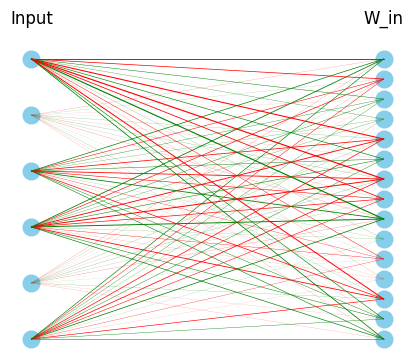

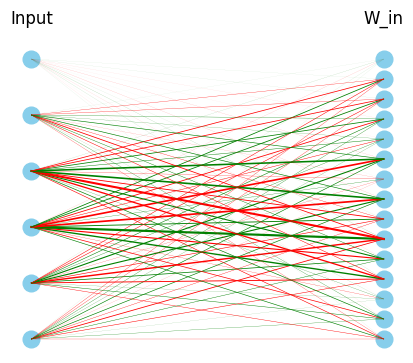

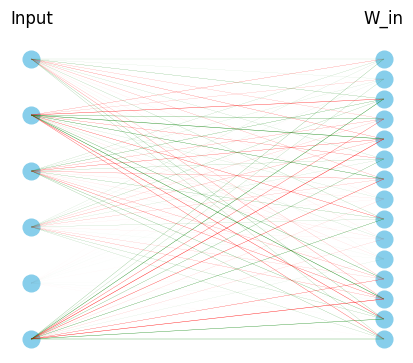

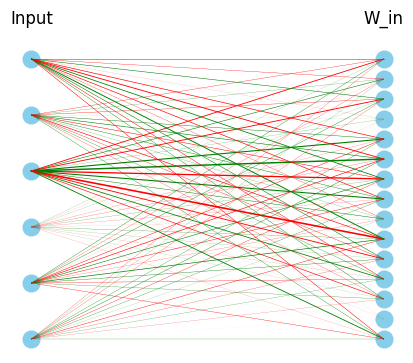

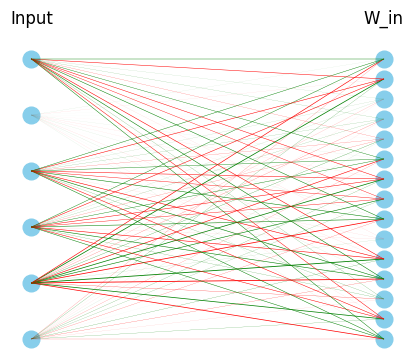

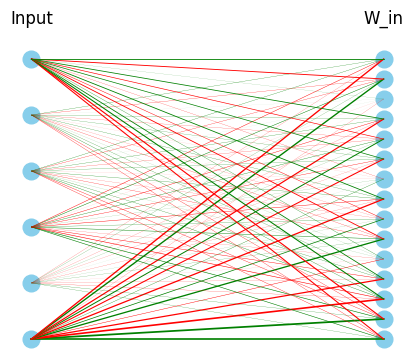

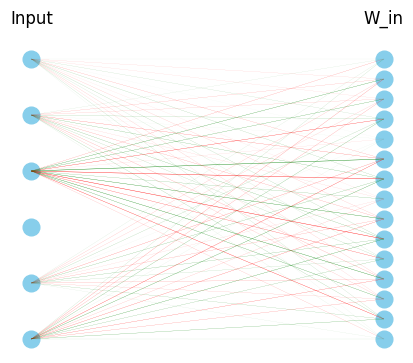

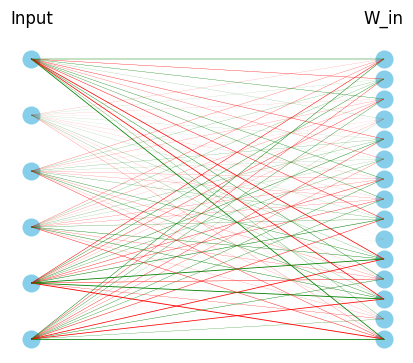

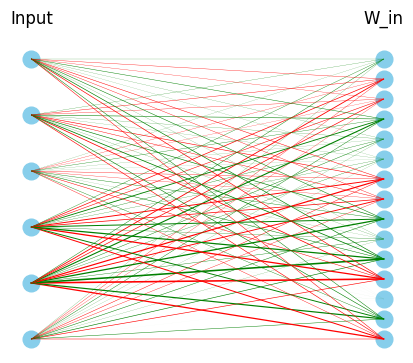

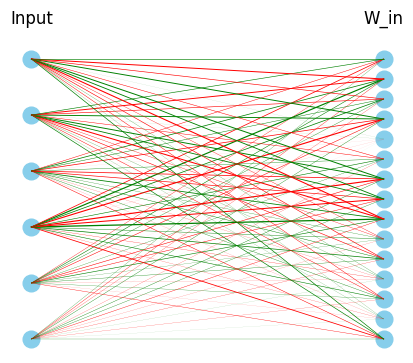

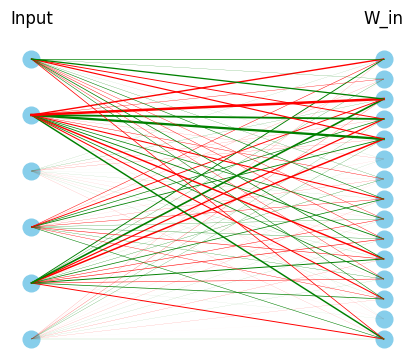

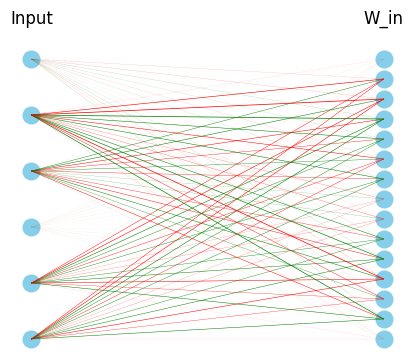

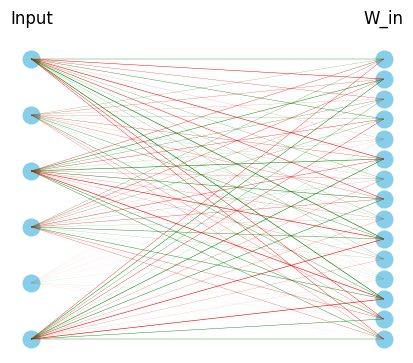

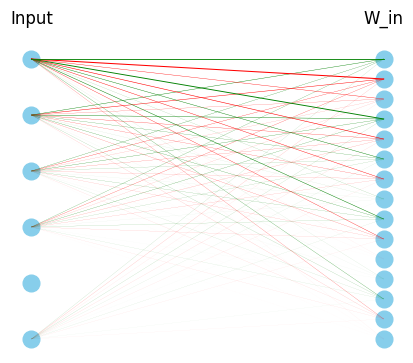

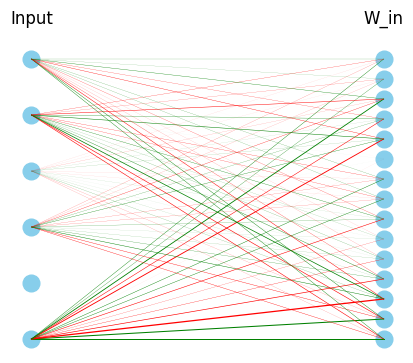

In [356]:
for i in range(15):
    test = torch.zeros_like(f_eye)
    test[i] = 1
    DrawNeuralNetwork(HoraDict(hora1_dict, hora2_dict, test))

In [249]:
recomposed = (hora1_dict['W_in'] @ hora2_dict['W_in'].transpose(0,1))
print((recomposed*100).round()/100)
#i = 0
#(hora1_dict['W_in'][:,[i]] @ hora2_dict['W_in'][:,[i]].transpose(0,1)*1000).round()/1000

tensor([[ 0.0400, -0.0400,  0.0100, -0.0100,  0.0000,  0.0000],
        [ 0.0600,  0.0200,  0.0100, -0.0100,  0.0000,  0.0100],
        [-0.0400,  0.0100, -0.0100,  0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0300, -0.0000,  0.0000, -0.0000, -0.0000],
        [-0.0000,  0.0300, -0.0000,  0.0000, -0.0000,  0.0000],
        [ 0.0300, -0.0000,  0.0300, -0.0300, -0.0000,  0.0100],
        [ 0.0000, -0.0000,  0.0200,  0.0100, -0.0000,  0.0000],
        [-0.0100,  0.0100, -0.0400,  0.0100,  0.0000, -0.0100],
        [ 0.0000, -0.0000, -0.0200, -0.0300,  0.0000, -0.0000],
        [-0.0100,  0.0000, -0.0000,  0.0200,  0.0000, -0.0100],
        [-0.0000, -0.0000, -0.0100,  0.0000,  0.0200, -0.0200],
        [ 0.0000, -0.0000,  0.0000, -0.0000,  0.0200,  0.0100],
        [-0.0000,  0.0000,  0.0000,  0.0000, -0.0300,  0.0100],
        [-0.0200,  0.0000, -0.0100,  0.0100, -0.0200, -0.0400],
        [ 0.0100, -0.0000,  0.0100, -0.0000,  0.0000,  0.0300]],
       device='cuda:0', grad_fn=<DivBac

In [230]:
param_dict['W_in']

tensor([[-0.6214,  0.7066,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8233, -0.3969,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8764, -0.2315,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5043,  0.7775,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0924, -0.8857,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.6214,  0.7066,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.8233, -0.3969,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.8764, -0.2315,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.5043,  0.7775,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0924, -0.8857,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.6214,  0.7066],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.8233, -0.3969],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.8764, -0.2315],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.5043,  0.7775],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0924, -0.8857]],
       device='cuda:0')

tensor([[ 0.5400, -0.5900, -0.0200,  0.0200,  0.0200, -0.0100],
        [ 0.6900,  0.3300,  0.0100, -0.0200, -0.0000,  0.0000],
        [-0.7500,  0.2200,  0.0000, -0.0200,  0.0200, -0.0000],
        [-0.4000, -0.6700, -0.0100,  0.0100, -0.0000, -0.0000],
        [-0.0700,  0.7500,  0.0100,  0.0000, -0.0200,  0.0200],
        [ 0.0100, -0.0400,  0.5400, -0.6000, -0.0100, -0.0000],
        [ 0.0000, -0.0000,  0.6700,  0.3600,  0.0100,  0.0100],
        [-0.0000, -0.0100, -0.7400,  0.2100, -0.0100,  0.0100],
        [-0.0400,  0.0200, -0.4300, -0.6700,  0.0100,  0.0100],
        [-0.0000,  0.0500, -0.0800,  0.7500,  0.0000,  0.0100],
        [-0.0200,  0.0100, -0.0100,  0.0000,  0.5000, -0.6000],
        [ 0.0000, -0.0100, -0.0300, -0.0300,  0.7000,  0.3100],
        [ 0.0100, -0.0100,  0.0100, -0.0100, -0.7400,  0.1800],
        [ 0.0100, -0.0000,  0.0100,  0.0100, -0.4200, -0.6500],
        [ 0.0200, -0.0100,  0.0500,  0.0300, -0.1000,  0.7600]],
       device='cuda:0', grad_fn=<DivBac

In [208]:
param_dict

{'W_in': tensor([[ 0.9328,  0.6234,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3228,  1.1125,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.1552,  0.0557,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.4134, -1.0439,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.8600, -0.7044,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.9328,  0.6234,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.3228,  1.1125,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.1552,  0.0557,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.4134, -1.0439,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.8600, -0.7044,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9328,  0.6234],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.3228,  1.1125],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -1.1552,  0.0557],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.4134, -1.0439],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.8600, -0.7044]],
        device='

In [26]:
j

torch.Size([10, 15])

In [6]:

output_target = 0*torch.rand_like(tms_model_p(X_tms_p[:10]))

base_KL = ((output_base - output_target)**2).mean()


output_hora = functional_call(
    tms_model_p, 
    HoraDict(param_dict, hora1_dict, hora2_dict, f_eye), (X_tms_p[:10],))


for test in range(10):
    sample_eye = torch.rand_like(f_eye).requires_grad_(True)

    output_base = tms_model_p(X_tms_p[:10])

    output_hora = functional_call(
        tms_model_p, 
        HoraDict(param_dict, hora1_dict, hora2_dict, sample_eye), (X_tms_p[:10],))

    singularity_loss = ((output_hora - output_base)**2).mean()
    singularity_loss.backward()
    grads = sum(abs(sample_eye.grad))
    

    grads



NameError: name 'output_base' is not defined

In [50]:
partial_func = partial(self.compute_loss, x)
jac = jacrev(partial_func, chunk_size=self.chunk_size)(self.param_dict)
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1e6} MB")
print(f"Cached memory: {torch.cuda.memory_reserved() / 1e6} MB")
j_vector = self.params_to_vectors(jac)
return j_vector


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0.,

In [28]:
def LoraShape(tensor):
    return einops.repeat(
        einops.einsum(
            tensor, 'h w ...->h ...'), 'h ... -> h ... r', r=n_features).shape


In [9]:
param_dict

{'W_in': tensor([[ 0.9437,  0.6047,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3062,  1.0906,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.1323,  0.0447,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3954, -1.0341,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.8638, -0.7229,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.9437,  0.6047,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.3062,  1.0906,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.1323,  0.0447,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.3954, -1.0341,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.8638, -0.7229,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9437,  0.6047],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.3062,  1.0906],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -1.1323,  0.0447],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.3954, -1.0341],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.8638, -0.7229]],
        device='

In [94]:
import eigenestimation_algorithm.gradientextractor
importlib.reload(eigenestimation_algorithm.gradientextractor)

from eigenestimation_algorithm.gradientextractor import (
    JacobianExtractor,
    ExtractJacs,
)

def Model0(x):
    return 0*torch.rand_like(x)
 

jac_extractor = JacobianExtractor(
        model=tms_model_p,
        model0 = Model0,
        loss = toy_models.tms.MSELoss(),
        chunk_size=100,
        param_dict=dict(tms_model_p.named_parameters())
)


dataloader = DataLoader(X_tms_p, batch_size=64, shuffle=False)
jacs, x = ExtractJacs(jac_extractor, dataloader)


Processing batch 1/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 2/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 3/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 4/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 5/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 6/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 7/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 8/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 9/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 10/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 11/104
Allocated memory: 3473.584128 MB
Cached memory: 3930.062848 MB
Processing batch 12/104
Allocated memory: 3473.58412

## Eigenestimation

In [131]:
#@title Train Eigenmodel
n_u_vectors = n_networks*n_features
batch_size = 16
lambda_penalty = [1,.1]
n_epochs = 1000
learning_rate = .01
torch.manual_seed(42)

dataloader = DataLoader(TensorDataset(x.to(device), jacs.to(device)),
 batch_size=batch_size, shuffle=True)

eigenmodel_tms_p = EigenEstimationComparison(
    tms_model_p.to(device), Model0, 
    toy_models.tms.MSELoss(), n_u_vectors).to(device)

TrainEigenEstimationComparison(eigenmodel_tms_p, dataloader, 
learning_rate, n_epochs, lambda_penalty, device='cuda', jac_chunk_size=None)


KeyboardInterrupt: 

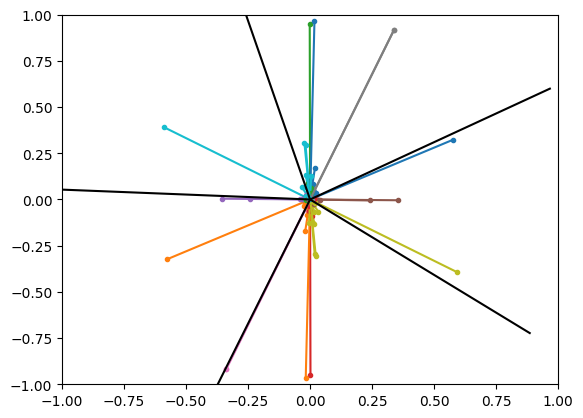

In [128]:
for u in [eigenmodel_tms_p.vector_to_parameters(u) for u in eigenmodel_tms_p.u]:
    u['W_in'] = u['W_in'].transpose(0,1)
    u['W_out'] = u['W_in'].transpose(0,1)
    for w1,w2 in u['W_in'][:2].transpose(0,1).detach().cpu().numpy():
        plt.plot([0,w1], [0,w2], '.-')
        plt.plot([0,-w1], [0,-w2], '.-')

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'k-')

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

[0, 1, 3, 3, 4, 5, 6, 7, 9, 10, 10, 12, 12, 14, 14]


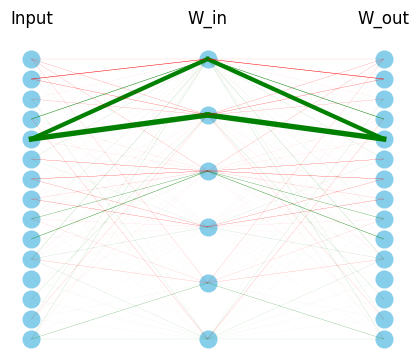

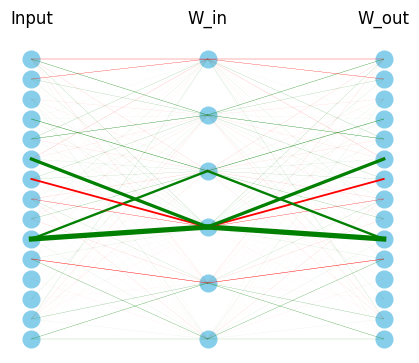

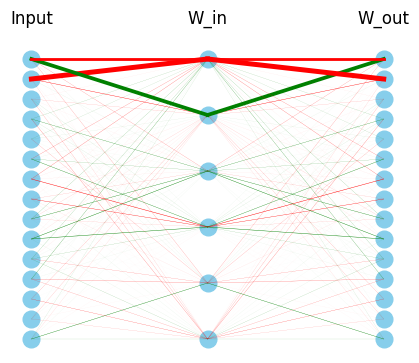

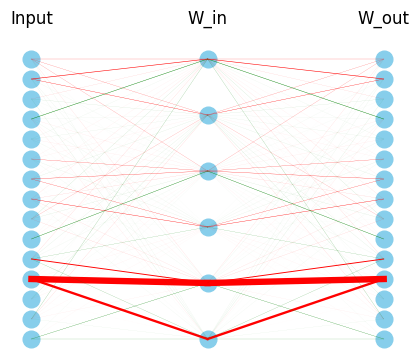

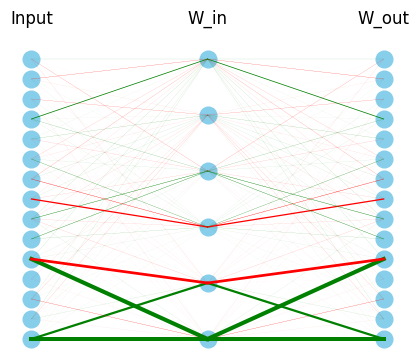

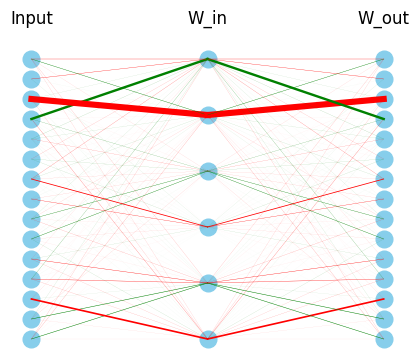

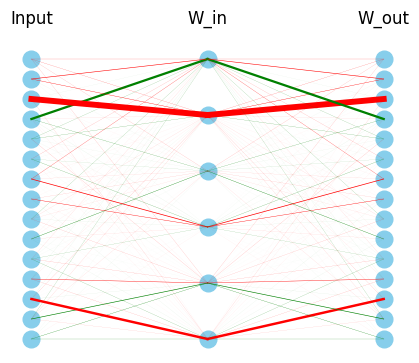

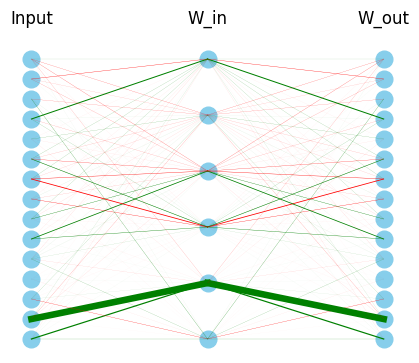

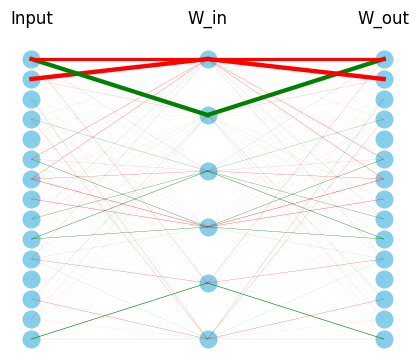

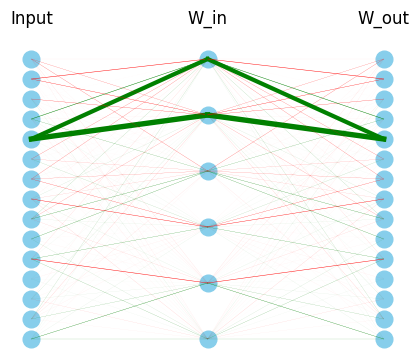

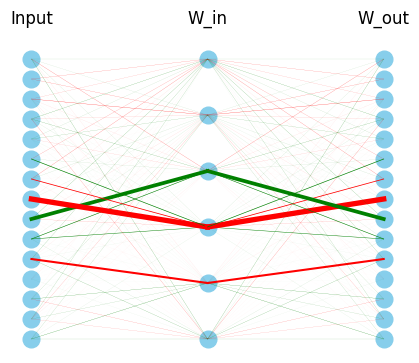

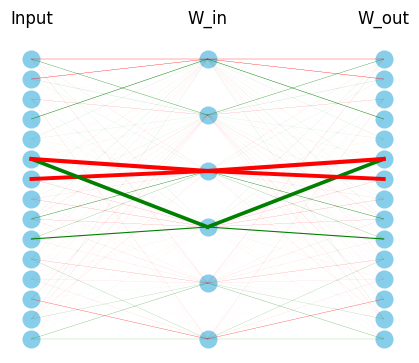

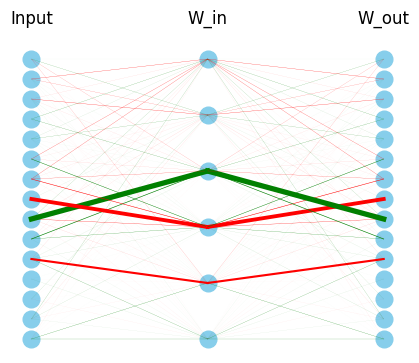

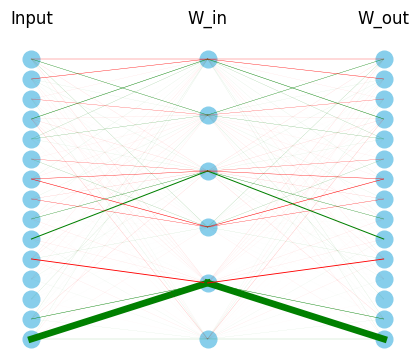

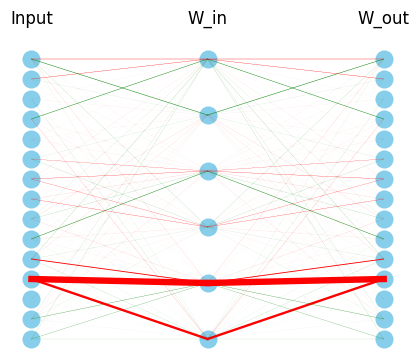

In [127]:
print(
    sorted([abs(eigenmodel_tms_p.vector_to_parameters(u)['W_in']).sum(dim=1).argmax().item() for u in eigenmodel_tms_p.u])
)
for u in [eigenmodel_tms_p.vector_to_parameters(u) for u in eigenmodel_tms_p.u]:
    u['W_in'] = u['W_in'].transpose(0,1)
    u['W_out'] = u['W_in'].transpose(0,1)
    DrawNeuralNetwork(u)
    

# Transformer






## Set up

In [53]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel
import transformer_lens
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
#gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
#tokenizer.pad_token = tokenizer.eos_token
#transformer_model = TransformerWrapper(gpt2, tokenizer)


#gpt2  = transformer_lens.HookedTransformer.from_pretrained('gpt2-small')
#tokenizer = gpt2.tokenizer

#gpt2  = transformer_lens.HookedTransformer.from_pretrained("roneneldan/TinyStories-33M")#
#tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
#tokenizer.pad_token = tokenizer.eos_token
#transformer_model = TransformerWrapper(gpt2, tokenizer)


model_name = "EleutherAI/pythia-410m"

# Load tokenizer
tokenizer0 = AutoTokenizer.from_pretrained(model_name)
tokenizer0.pad_token = tokenizer0.eos_token

# Load model at checkpoint 1
model0 = AutoModelForCausalLM.from_pretrained(model_name, revision='step1')
model = AutoModelForCausalLM.from_pretrained(model_name)
transformer_model0 = TransformerWrapper(model0.to(device), tokenizer0, outputs_logits=False).requires_grad_(False).to(device)
transformer_model = TransformerWrapper(model.to(device), tokenizer0, outputs_logits=False).to(device)
print( [(name, param.numel()) for name, param in transformer_model.named_parameters()])
#transformer_model0  = transformer_lens.HookedTransformer.from_pretrained("roneneldan/TinyStories-2Layers-33M")#
#tokenizer0 = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
##tokenizer.pad_token = tokenizer.eos_token
#transformer_model0 = TransformerWrapper(transformer_model0, tokenizer0).requires_grad_(False)


# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if #('blocks.4.attn.W' not in p)]# and ('blocks.6.mlp.W' not in p)]#!='transformer.h.1.ln_2.weight']
   '12.attention.query_key_value.bias' not in p]#!='transformer.h.1.ln_2.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,p in transformer_model.named_parameters(): print(n, p.shape, p.numel())


# Load in data.
dataset = load_dataset('roneneldan/TinyStories', split="validation")
X_transformer = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length = 24, add_bos_token=False)['tokens']
print(X_transformer.shape)

[('transformer.gpt_neox.embed_in.weight', 51511296), ('transformer.gpt_neox.layers.0.input_layernorm.weight', 1024), ('transformer.gpt_neox.layers.0.input_layernorm.bias', 1024), ('transformer.gpt_neox.layers.0.post_attention_layernorm.weight', 1024), ('transformer.gpt_neox.layers.0.post_attention_layernorm.bias', 1024), ('transformer.gpt_neox.layers.0.attention.query_key_value.weight', 3145728), ('transformer.gpt_neox.layers.0.attention.query_key_value.bias', 3072), ('transformer.gpt_neox.layers.0.attention.dense.weight', 1048576), ('transformer.gpt_neox.layers.0.attention.dense.bias', 1024), ('transformer.gpt_neox.layers.0.mlp.dense_h_to_4h.weight', 4194304), ('transformer.gpt_neox.layers.0.mlp.dense_h_to_4h.bias', 4096), ('transformer.gpt_neox.layers.0.mlp.dense_4h_to_h.weight', 4194304), ('transformer.gpt_neox.layers.0.mlp.dense_4h_to_h.bias', 1024), ('transformer.gpt_neox.layers.1.input_layernorm.weight', 1024), ('transformer.gpt_neox.layers.1.input_layernorm.bias', 1024), ('trans

## Eigenestimation

### Pull Gradients

In [65]:
import eigenestimation_algorithm.gradientextractor
importlib.reload(eigenestimation_algorithm.gradientextractor)

from eigenestimation_algorithm.gradientextractor import (
    JacobianExtractor,
    ExtractJacs,
)

param_dict = {name: param.detach().clone() for name, param in transformer_model.named_parameters()}

jac_extractor = JacobianExtractor(
        model=transformer_model.to(device),
        model0 = transformer_model0.to(device),
        loss = KLDivergenceLoss(),
        chunk_size=50, 
        param_dict = param_dict
)

torch.cuda.empty_cache()
gc.collect()

dataloader = DataLoader(X_transformer[::500,].to(device), batch_size=16, shuffle=False)
jacs, x = ExtractJacs(jac_extractor, dataloader)
torch.save(x, "../data/transformer/x.pt")
torch.save(jacs, "../data/transformer/jacs.pt")


Processing batch 1/25
Allocated memory: 7309.643264 MB
Cached memory: 23829.938176 MB
Processing batch 2/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 3/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 4/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 5/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 6/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 7/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 8/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 9/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 10/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 11/25
Allocated memory: 7309.643264 MB
Cached memory: 23804.772352 MB
Processing batch 12/25
Allocated memory: 7309.643264

In [15]:
prompt = "How can I improve my research?"

input_ids = tokenizer0(prompt, return_tensors="pt").input_ids

gen_tokens = model0.generate(
    input_ids.to(device),
    do_sample=True,
    temperature=0.9,
    max_length=100,
)
gen_text = tokenizer0.batch_decode(gen_tokens)[-1]
gen_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'How can I improve my research?igraphy conceded ",ringer solutions exc SeverClickVERTGreen Carb Patriotsnest Carb confereren replicaOffsetreqュSouth medianrequentlyDEBUG dielectrichosClick exc]\\]Met formulate� analgesic parentheses silent stewoidesMEDdiscussion keen keen appellate airst 161 November Nich pert pe median curvature wells Him clutchClick wellsuba imbalance wellsentesinset germination opaqueruary ferry Fivericting metabolitesraintelig Richardsgger harassment Nich Arabidopsis对 Lance crunchvcfalsemucherent${对CAR Ré median эт WithinitatPaint canineruaryindex'

In [66]:
x = torch.load("../data/transformer/x.pt", weights_only=True)
jacs = torch.load("../data/transformer/jacs.pt", weights_only=True)


In [105]:
#@title Train Eigenmodel

torch.cuda.empty_cache()
gc.collect()

n_u_vectors = 50
batch_size = 32
lambda_penalty = [1,0]
n_epochs = 1000
learning_rate = .001
torch.manual_seed(42)
dataloader = DataLoader(TensorDataset(x.to(device), jacs.to(device)),
 batch_size=batch_size, shuffle=True)

eigenmodel_transformer = EigenEstimationComparison(
    transformer_model.to(device), transformer_model0, 
    KLDivergenceLoss(), n_u_vectors).to(device)

TrainEigenEstimationComparison(eigenmodel_transformer, dataloader, 
learning_rate, n_epochs, lambda_penalty, device='cuda')


RuntimeError: einsum(): subscript a has size 3072 for operand 1 which does not broadcast with previously seen size 90

In [73]:
def PrintActivatingExamplesTransformer(
    eigenmodel: torch.nn.Module,
    dataloader_X,
    feature_idx: int,
    top_k: int,
    batch_size: int = 32,  # Define a batch size for minibatch processing,
    device: str = 'cuda', 
    k_logits: int = 5
) -> None:
    
    # Split X into minibatches
    dH_list = []
    X = []
    bottom_logits_list = []
    top_logits_list = []
    with torch.no_grad():
        for x,jac in dataloader_X:
            H = einops.einsum(jac.to(device), eigenmodel.u[feature_idx], '... w, w -> ...')            
            dH_list.append(H)
            X.append(x)
    
    if True:#for f in feature_idx:

        # Concatenate dH results from all minibatches
        feature_vals = (torch.cat(dH_list, dim=0))
        X = (torch.cat(X, dim=0))

        #top_logits_idx = torch.cat(top_logits_list, dim=1)
        #bottom_logits_idx = torch.cat(bottom_logits_list, dim=1)

        # Flatten the tensor to find the top k values globally
        flattened_tensor = feature_vals.flatten()
        #print(top_logits_idx.shape)
        # Find the top 5 highest values and their indices in the flattened tensor
        top_values, top_idx = torch.topk((flattened_tensor), top_k, largest=True)
        # Convert the flattened indices back to the original 3D indices
        top_idx_sample, top_idx_token = torch.unravel_index(top_idx, feature_vals.shape)


        # Iterate over the top values and their indices
        for (sample, token, value) in zip(top_idx_sample, top_idx_token, top_values):
            #print(sample, token, value)
            # Decode the entire sequence of tokens for the current sample as individual tokens
            tokens_list = eigenmodel.model.tokenizer.convert_ids_to_tokens(X[sample].tolist())
            
            # Bold the token at the specific index
            tokens_list[token] = f"**{tokens_list[token]}**"
            
            # Join the tokens back together for displaying
            bolded_tokens = eigenmodel.model.tokenizer.convert_tokens_to_string(tokens_list[:(token+1)])
            bolded_tokens = bolded_tokens.replace("\n", "newline")

            # Decode the specific token with the highest value
            token_of_value = eigenmodel.model.tokenizer.decode(X[sample, token]).replace("\n", "newline")
            
            #top_logits =  [eigenmodel.model.tokenizer.decode(i) for i in (top_logits_idx[:,sample,token])]
            #bottom_logits =  [eigenmodel.model.tokenizer.decode(i) for i in (bottom_logits_idx[:,sample,token])]


            # Print the modified tokens with the bolded token and its value
            print(f"{bolded_tokens} -> {token_of_value} (Value: {value:.3f})")# top: {top_logits}, bottom: {bottom_logits}")

for i in range(50):
    print(f'---------{i}--------')
    PrintActivatingExamplesTransformer(
        eigenmodel_transformer,
        dataloader,
        i,
        5)

---------0--------
 He looked around and saw a duck.newlinenewlineâ€œHello,â€ said the rabbit. â**€** -> € (Value: 0.009)
 He looked around and saw a duck.newlinenewlineâ€œHello,â**€** -> € (Value: 0.007)
 story. She was very happy.Once upon a time, there lived a turtle named Trey.** T** ->  T (Value: 0.006)
 letting her take it** with** ->  with (Value: 0.006)
 day and build sand**cast** -> cast (Value: 0.005)
---------1--------
?â€newlinenewline**â** -> â (Value: 0.014)
 said, "I love you!"Ben saw a** beet** ->  beet (Value: 0.011)
 day and build sand**cast** -> cast (Value: 0.008)
 a time there was a boy, who was searching** high** ->  high (Value: 0.008)
 a time there was a boy, who was searching high** and** ->  and (Value: 0.008)
---------2--------
 the trunk and shouted to Mum, â€œ**M** -> M (Value: 0.006)
 Max were playing with their toy boats in the** bat** ->  bat (Value: 0.006)
 made Benny really curious! He wanted to touch it.newlinenewline**B** -> B (Value: 0.005)
 he woul

In [111]:
#@title Train Eigenmodel
n_u_vectors = 20
batch_size = 16
lambda_penalty = [1,.1]
n_epochs = 10
learning_rate = .001

torch.cuda.empty_cache()
gc.collect()

x_transformer_dataloader = DataLoader(X_transformer[:100,], batch_size=batch_size, shuffle=True)

torch.cuda.empty_cache()
gc.collect()

def custom_loss(outputs, truth):
    truth_rearranged = einops.rearrange(truth, '... p -> (...) p')
    outputs_rearranged = einops.rearrange(outputs, '... p -> (...) p')

    # Randomly select 3 indices based on probabilities in the last dimension
    selected_indices = torch.multinomial(truth_rearranged, num_samples=2, replacement=True)
    out = torch.gather(outputs_rearranged, 1, selected_indices) #nn.KLDivLoss(reduction='batchmean')(torch.log(torch.gather(truth_rearranged, 1, selected_indices)), torch.gather(outputs_rearranged, 1, selected_indices))
    return out

def M0(x):
    return (torch.ones_like(transformer_model(x))).softmax(dim=-1)

eigenmodel_transformer = EigenEstimationComparison(transformer_model, transformer_model,
                         custom_loss, n_u_vectors).to(device)

TrainEigenEstimationComparison(eigenmodel_transformer, x_transformer_dataloader, learning_rate, n_epochs, lambda_penalty, device='cuda', jac_chunk_size=50)


KeyboardInterrupt: 

In [114]:
custom_loss(eigenmodel_transformer.model(X_transformer[:10]), eigenmodel_transformer.model0(X_transformer[:10])).shape

torch.Size([240, 2])

In [108]:
a = eigenmodel_transformer(X_transformer[:10], param_dict=eigenmodel_transformer.param_dict, chunk_size=10).flatten()

torch.Size([20, 240, 1])

In [57]:
nn.KLDivLoss(reduction='batchmean')(torch.log(selected_values), selected_values)

tensor(-0.0633, device='cuda:0')

In [352]:
probs_rearranged.shape

torch.Size([50257, 240])

In [346]:
def select(x):
    idxs = torch.multinomial(x, num_samples=3 ,replacement=True)
    return x[idxs]
torch.apply_along_dim(probs, select)

AttributeError: module 'torch' has no attribute 'apply_along_dim'

### Eval

In [34]:
for i in range(10):
    print(f'------{i}---------')
    with torch.no_grad():
        PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[::100], i, top_k=3, batch_size=64)

------0---------


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

tensor([[ 1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
          1.0000,  1.0000],
        [ 1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
          1.0000,  1.0000],
        [-1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
         -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
         -1.0000, -1.0000],
        [ 1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
          1.0000,  1.0000],
        [-1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
         -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
         -1.0000, -1.0000],
        [ 1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
          1.0000,  1.0000],
        [ 1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
          1.0000,  1.0000],
        [ 1.0000,  

In [147]:
torch.cat(dH_list, dim=1).shape

torch.Size([5, 48])

In [144]:
feature_vals.shape

torch.Size([240])

In [62]:
x_transformer_dataloader_eval = DataLoader(X_transformer, batch_size=batch_size, shuffle=True)

for x in x_transformer_dataloader_eval:
    dP_du, _ = eigenmodel_transformer(x.to(device), eigenmodel_transformer.param_dict) # n_classes n_u
    break


In [66]:
 dP_du, _ = eigenmodel(x.to(device), eigenmodel.param_dict)

torch.Size([8, 24])

In [67]:
device

'cuda'

In [88]:
eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1)

tensor([[ 1.0000, -0.8526,  0.9410, -0.6775,  0.9522, -0.8299, -0.9275, -0.6635,
         -0.7020,  0.9370,  0.9326,  0.9004, -0.9586,  0.9389, -0.9626,  0.9478,
          0.9249, -0.9289, -0.6910, -0.9205],
        [-0.8526,  1.0000, -0.8685,  0.7758, -0.8562,  0.8244,  0.8882,  0.7295,
          0.7002, -0.8480, -0.8699, -0.8901,  0.8728, -0.8744,  0.8820, -0.8974,
         -0.9167,  0.8946,  0.7196,  0.8929],
        [ 0.9410, -0.8685,  1.0000, -0.7059,  0.9649, -0.8325, -0.9693, -0.7162,
         -0.7008,  0.9456,  0.8843,  0.9516, -0.9445,  0.9431, -0.9713,  0.9679,
          0.9429, -0.9220, -0.6750, -0.9626],
        [-0.6775,  0.7758, -0.7059,  1.0000, -0.6920,  0.8437,  0.7250,  0.9455,
          0.9292, -0.6925, -0.7349, -0.7497,  0.6945, -0.7243,  0.6992, -0.7167,
         -0.7398,  0.7151,  0.9291,  0.7344],
        [ 0.9522, -0.8562,  0.9649, -0.6920,  1.0000, -0.7971, -0.9522, -0.6712,
         -0.6899,  0.9405,  0.8968,  0.9281, -0.9753,  0.9077, -0.9808,  0.9663,
      

# Eigenestimation

# Tests on Toy Models


## XORNet

In [152]:
torch.manual_seed(42)
X_xornet, Y_xornet, dataloader_xornet = GenerateXORData(n_repeats=100, batch_size=32)
model_xornet = XORNet().to(device)
 

_, _, _ =TrainModel(
    model=model_xornet,
    criterion=nn.MSELoss(),
    learning_rate=.01,
    dataloader=dataloader_xornet,
    n_epochs=1000,
    device=device
)

list(model_xornet.named_parameters())

TypeError: to() received an invalid combination of arguments - got (tuple), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


## Xornet

In [912]:
n_u_vectors = 3
batch_size = 16
lambda_penalty = 100
repeats = 48
n_epochs = 100
learning_rate = .01

params_to_delete = [name for name, param in model_xornet.named_parameters() if "weight" not in name]

DeleteParams(model_xornet, params_to_delete)

torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet = EigenEstimation(model_xornet.to(device), lambda x,y :x, n_u_vectors).to(device)
#nn.MSELoss(reduction='none')(x,y).mean(dim=-1).unsqueeze(-1), 


dataloader_xornet_eigen = DataLoader(
    (einops.repeat(X_xornet, 's f -> (s r) f', r=repeats)), batch_size=batch_size, shuffle=True)

TrainEigenEstimation(eigenmodel_xornet, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty, device=device)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()





Epoch 0 : 1059.458,  High Hessian Loss: 8.906,  Basis Loss: 10.684
Epoch 1 : 419.446,  High Hessian Loss: 5.517,  Basis Loss: 4.250
Epoch 2 : 263.072,  High Hessian Loss: 5.060,  Basis Loss: 2.681
Epoch 3 : 170.152,  High Hessian Loss: 4.393,  Basis Loss: 1.745
Epoch 4 : 125.653,  High Hessian Loss: 4.006,  Basis Loss: 1.297


Epoch 5 : 105.311,  High Hessian Loss: 3.829,  Basis Loss: 1.091
Epoch 6 : 95.454,  High Hessian Loss: 3.681,  Basis Loss: 0.991
Epoch 7 : 88.556,  High Hessian Loss: 3.561,  Basis Loss: 0.921
Epoch 8 : 81.533,  High Hessian Loss: 3.422,  Basis Loss: 0.850
Epoch 9 : 75.165,  High Hessian Loss: 3.300,  Basis Loss: 0.785
Epoch 10 : 68.406,  High Hessian Loss: 3.150,  Basis Loss: 0.716
Epoch 11 : 61.845,  High Hessian Loss: 3.015,  Basis Loss: 0.649
Epoch 12 : 55.955,  High Hessian Loss: 2.888,  Basis Loss: 0.588
Epoch 13 : 50.719,  High Hessian Loss: 2.753,  Basis Loss: 0.535
Epoch 14 : 44.938,  High Hessian Loss: 2.608,  Basis Loss: 0.475
Epoch 15 : 40.365,  High Hessian Loss: 2.491,  Basis Loss: 0.429
Epoch 16 : 36.120,  High Hessian Loss: 2.353,  Basis Loss: 0.385
Epoch 17 : 31.941,  High Hessian Loss: 2.240,  Basis Loss: 0.342
Epoch 18 : 28.001,  High Hessian Loss: 2.109,  Basis Loss: 0.301
Epoch 19 : 24.904,  High Hessian Loss: 1.998,  Basis Loss: 0.269
Epoch 20 : 21.994,  High Hess

386

In [914]:
# Look at features
print(eigenmodel_xornet.u @ eigenmodel_xornet.u.transpose(0,1))

for f_idx in range(eigenmodel_xornet.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet.to(device), eigenmodel_xornet.to(device), f_idx, 4, device=device)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

tensor([[ 1.0000, -0.3266,  0.0251],
        [-0.3266,  1.0000,  0.8394],
        [ 0.0251,  0.8394,  1.0000]], device='cuda:0', grad_fn=<MmBackward0>)
feature 0
[0. 0.] -> 0.014335279
[1. 1.] -> 0.008720554
[0. 1.] -> 0.007262003
[1. 0.] -> 0.007208454
feature 1
[0. 0.] -> 0.011567957
[1. 0.] -> 0.0035192836
[0. 1.] -> 0.0032086803
[1. 1.] -> 0.0018797998
feature 2
[0. 0.] -> 0.016717711
[0. 1.] -> 0.0026528111
[1. 0.] -> 0.002562845
[1. 1.] -> 0.001165661


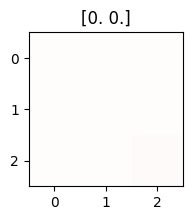

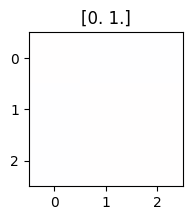

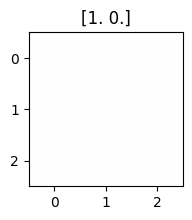

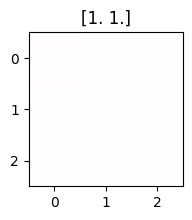

{'fc1.weight': tensor([[ 0.6095,  0.0181],
        [ 0.2901, -0.0073]], device='cuda:0', grad_fn=<ViewBackward0>), 'fc2.weight': tensor([[ 0.7107, -0.1970]], device='cuda:0', grad_fn=<ViewBackward0>)}
{'fc1.weight': tensor([[-0.2842, -0.3100],
        [ 0.2832,  0.4060]], device='cuda:0', grad_fn=<ViewBackward0>), 'fc2.weight': tensor([[-0.4822, -0.5878]], device='cuda:0', grad_fn=<ViewBackward0>)}
{'fc1.weight': tensor([[ 0.0255, -0.6203],
        [ 0.3884,  0.1185]], device='cuda:0', grad_fn=<ViewBackward0>), 'fc2.weight': tensor([[-0.2950, -0.6022]], device='cuda:0', grad_fn=<ViewBackward0>)}


In [915]:
dP_du, FIM_diag= eigenmodel_xornet(X_xornet.to(device), eigenmodel_xornet.u)
if True:
        FIM_diag = einops.einsum(dP_du, dP_du, 'v1 ... c, v2 ... c -> v1 v2 ...') #/  dP_du.shape[-1]
        H = einops.einsum(dP_du, dP_du, 'v1 ... p, v2 ... p -> v1 v2 ...')
for i in range(H.shape[-1]):
        plt.figure(figsize=(2,2))
        plt.imshow(H[:,:,i].detach().cpu().numpy(), cmap='bwr', vmax=1, vmin=-1)
        plt.title(X_xornet[i].detach().cpu().numpy())
        plt.show()


for u in [eigenmodel_xornet.vector_to_parameters(u) for u in eigenmodel_xornet.u]:
        print(u)

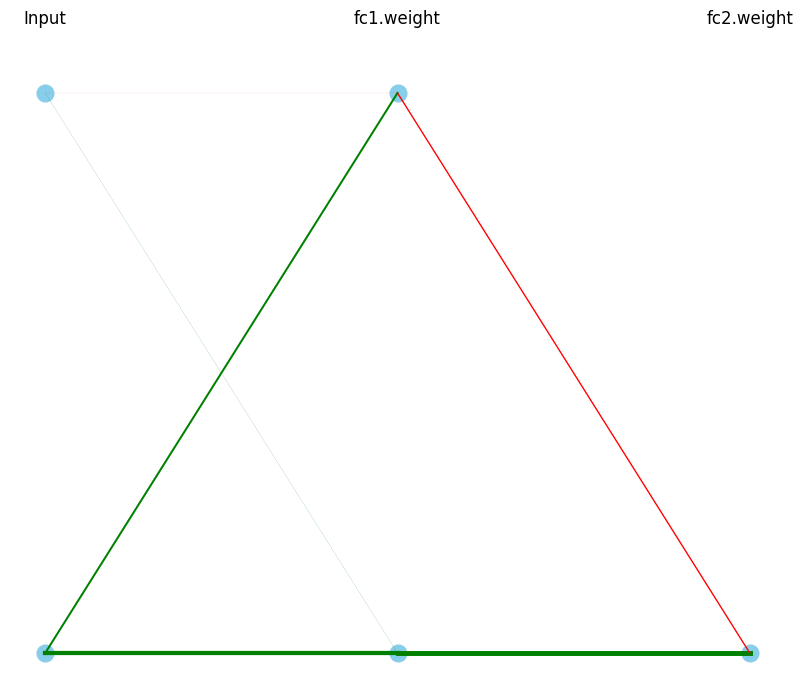

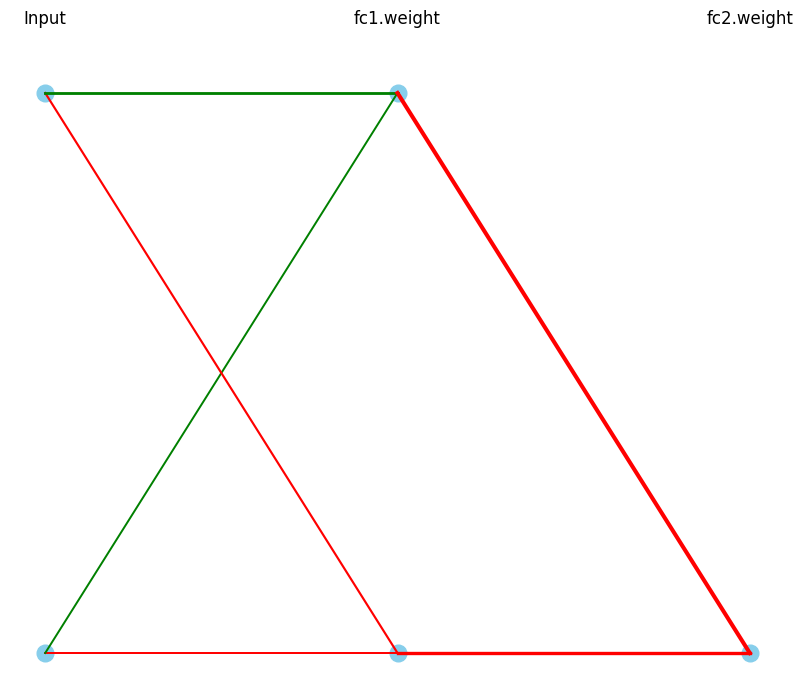

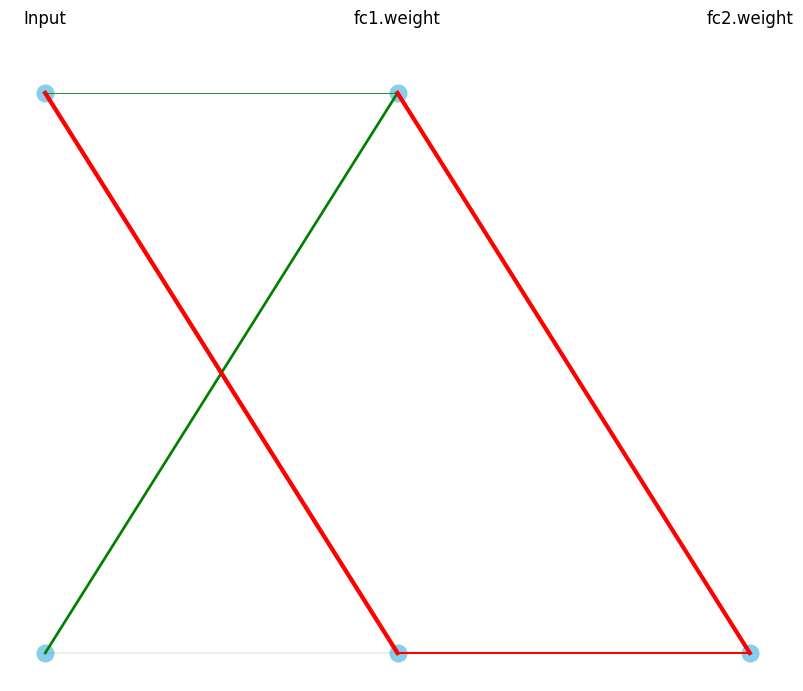

In [916]:
for u in [eigenmodel_xornet.vector_to_parameters(u) for u in eigenmodel_xornet.u]:
    DrawNeuralNetwork(u)

## XORNet parallel

In [875]:
torch.manual_seed(42)
n_networks = 2
X_xornet_p, Y_xornet_p, dataloader_xornet_p = GenerateXORDataParallel(n_repeats=64, n_networks=n_networks, batch_size=32)
model_xornet_p = XORNetParallel(n_networks).to(device)


for n,p in model_xornet.named_parameters():
    if "weight" in n:
        dict(model_xornet_p.named_parameters())[n].data = torch.block_diag(*[p for _ in range(n_networks)])
    if "bias" in n:
        dict(model_xornet_p.named_parameters())[n].data = torch.concat([p for _ in range(n_networks)])


params_to_delete = [name for name, param in model_xornet_p.named_parameters() if "weight" not in name]

DeleteParams(model_xornet_p, params_to_delete)



print(dict(model_xornet_p.named_parameters()))

{'fc1.weight': Parameter containing:
tensor([[1.2623, 2.0115, 0.0000, 0.0000],
        [0.7025, 1.1278, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2623, 2.0115],
        [0.0000, 0.0000, 0.7025, 1.1278]], device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[-1.5507,  1.4093,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.5507,  1.4093]], device='cuda:0',
       requires_grad=True)}


In [876]:
n_u_vectors = 2
batch_size = 64
lambda_penalty = 1
n_epochs = 100
learning_rate = .01


torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet_p = EigenEstimation(model_xornet_p.to(device), lambda x,y :x, n_u_vectors).to(device)
#nn.MSELoss(reduction='none')(x,y).mean(dim=-1).unsqueeze(-1), 


dataloader_xornet_eigen = DataLoader(
   (einops.repeat(X_xornet_p, 's f -> (s r) f', r=repeats)), batch_size=batch_size, shuffle=True)

TrainEigenEstimation(eigenmodel_xornet_p, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty, device=device)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()


Epoch 0 : -1089.653,  High Hessian Loss: 1111.940,  Basis Loss: 22.287
Epoch 2 : -28782.529,  High Hessian Loss: 28861.285,  Basis Loss: 78.753
Epoch 4 : -39616.461,  High Hessian Loss: 39727.312,  Basis Loss: 110.850
Epoch 6 : -39985.805,  High Hessian Loss: 40102.547,  Basis Loss: 116.744


Epoch 8 : -39960.520,  High Hessian Loss: 40078.363,  Basis Loss: 117.845
Epoch 10 : -39924.922,  High Hessian Loss: 40043.391,  Basis Loss: 118.471
Epoch 12 : -39916.621,  High Hessian Loss: 40035.016,  Basis Loss: 118.393
Epoch 14 : -39921.500,  High Hessian Loss: 40040.059,  Basis Loss: 118.556
Epoch 16 : -39919.859,  High Hessian Loss: 40038.895,  Basis Loss: 119.036
Epoch 18 : -39935.762,  High Hessian Loss: 40054.695,  Basis Loss: 118.932
Epoch 20 : -39917.008,  High Hessian Loss: 40035.840,  Basis Loss: 118.836
Epoch 22 : -39906.711,  High Hessian Loss: 40025.590,  Basis Loss: 118.881
Epoch 24 : -39919.188,  High Hessian Loss: 40038.102,  Basis Loss: 118.913
Epoch 26 : -39932.469,  High Hessian Loss: 40051.543,  Basis Loss: 119.076
Epoch 28 : -39928.621,  High Hessian Loss: 40047.918,  Basis Loss: 119.298
Epoch 30 : -39925.289,  High Hessian Loss: 40044.379,  Basis Loss: 119.089
Epoch 32 : -39932.211,  High Hessian Loss: 40051.516,  Basis Loss: 119.298
Epoch 34 : -39922.684,  Hi

KeyboardInterrupt: 

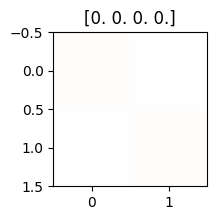

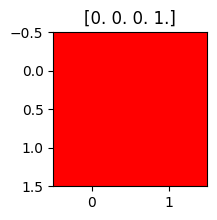

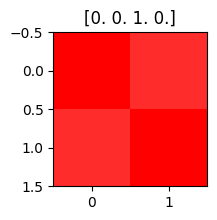

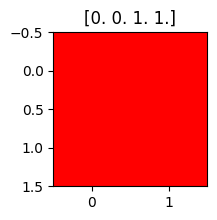

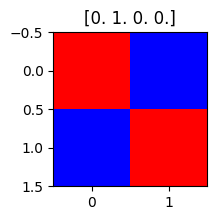

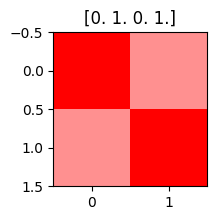

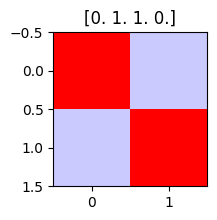

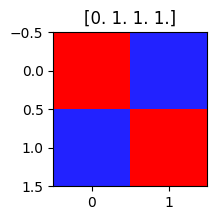

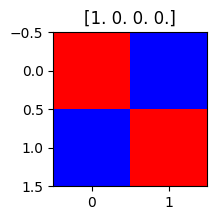

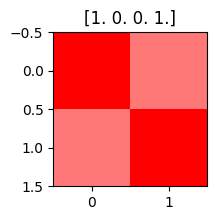

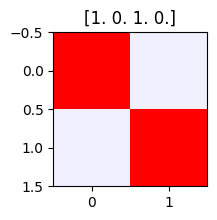

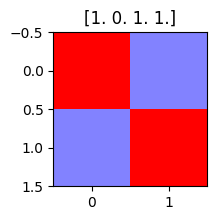

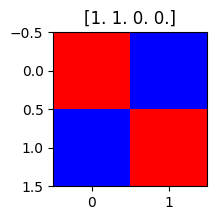

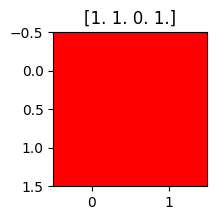

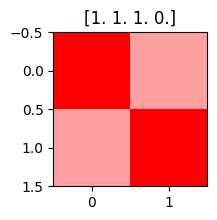

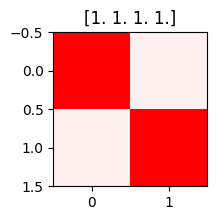

{'fc1.weight': tensor([[ 0.2021,  0.2024,  0.2029,  0.2021],
        [-0.2019, -0.2024, -0.2026, -0.2018],
        [-0.2056, -0.2059, -0.2064, -0.2055],
        [ 0.2055,  0.2058,  0.2062,  0.2054]], device='cuda:0',
       grad_fn=<ViewBackward0>), 'fc2.weight': tensor([[-0.2027, -0.2024, -0.2024, -0.2026],
        [ 0.2064,  0.2062,  0.2058,  0.2060]], device='cuda:0',
       grad_fn=<ViewBackward0>)}
{'fc1.weight': tensor([[-0.2058, -0.2062, -0.2064, -0.2055],
        [ 0.2056,  0.2062,  0.2062,  0.2052],
        [-0.2020, -0.2023, -0.2028, -0.2017],
        [ 0.2019,  0.2023,  0.2025,  0.2017]], device='cuda:0',
       grad_fn=<ViewBackward0>), 'fc2.weight': tensor([[0.2065, 0.2062, 0.2058, 0.2060],
        [0.2029, 0.2027, 0.2021, 0.2023]], device='cuda:0',
       grad_fn=<ViewBackward0>)}


In [877]:
dP_du, FIM_diag= eigenmodel_xornet_p(X_xornet_p.to(device), eigenmodel_xornet_p.u)
if True:
        FIM_diag = einops.einsum(dP_du, dP_du, 'v1 ... c, v2 ... c -> v1 v2 ...') #/  dP_du.shape[-1]
        H = einops.einsum(dP_du, dP_du, 'v1 ... p, v2 ... p -> v1 v2 ...')
for i in range(H.shape[-1]):
        plt.figure(figsize=(2,2))
        plt.imshow(H[:,:,i].detach().cpu().numpy(), cmap='bwr', vmax=.5, vmin=-.5)
        plt.title(X_xornet_p[i].detach().cpu().numpy())
        plt.show()


for u in [eigenmodel_xornet_p.vector_to_parameters(u) for u in eigenmodel_xornet_p.u]:
        print(u)

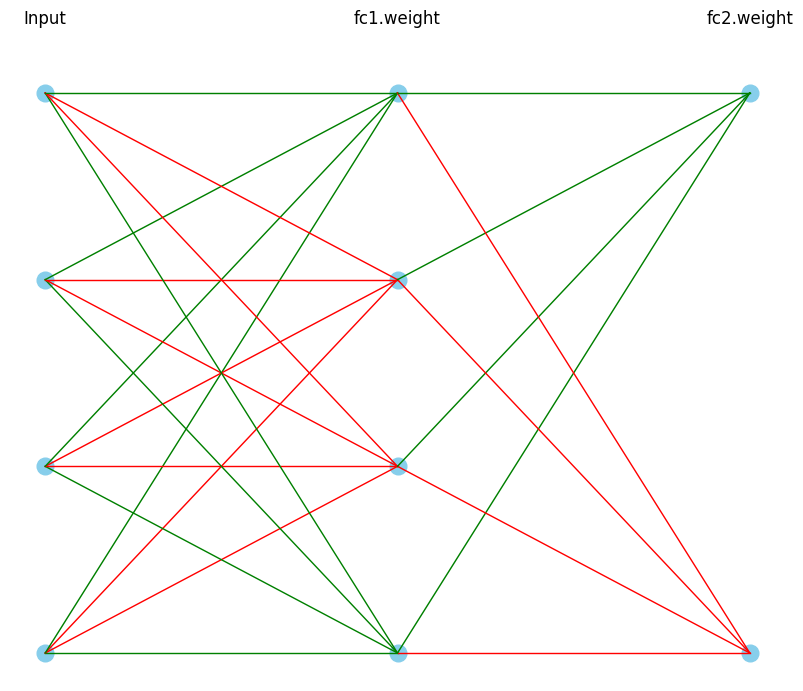

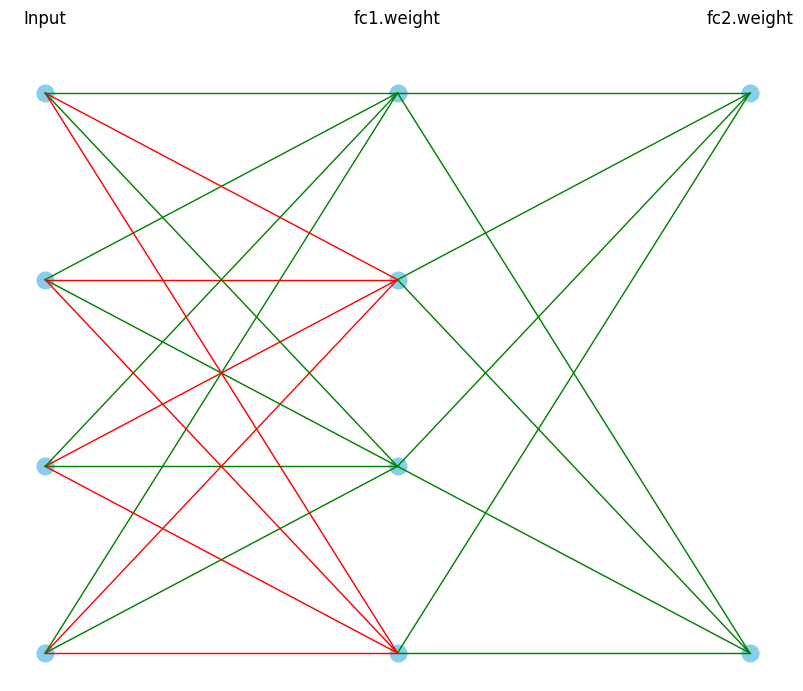

In [878]:
for u in [eigenmodel_xornet_p.vector_to_parameters(u) for u in eigenmodel_xornet_p.u]:
    DrawNeuralNetwork(u)

In [853]:
eigenmodel_xornet_p.u @ eigenmodel_xornet_p.u.transpose(0,1)

tensor([[ 1.0000,  0.1702,  0.2694, -0.2134, -0.4801, -0.3826],
        [ 0.1702,  1.0000,  0.3060,  0.0489,  0.0037, -0.1256],
        [ 0.2694,  0.3060,  1.0000,  0.0967,  0.2482,  0.0722],
        [-0.2134,  0.0489,  0.0967,  1.0000, -0.0105, -0.2286],
        [-0.4801,  0.0037,  0.2482, -0.0105,  1.0000,  0.1480],
        [-0.3826, -0.1256,  0.0722, -0.2286,  0.1480,  1.0000]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [854]:
# Look at features
for f_idx in range(eigenmodel_xornet_p.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet_p.to(device), eigenmodel_xornet_p.to(device), f_idx, 8, device=device)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

feature 0
[1. 0. 0. 0.] -> 0.006021642
[1. 0. 1. 1.] -> 0.0055816094
[0. 1. 1. 0.] -> 0.003550117
[1. 0. 0. 1.] -> 0.0031602364
[1. 0. 1. 0.] -> 0.002849863
[1. 1. 1. 1.] -> 0.0019911926
[1. 1. 1. 0.] -> 0.0018207284
[0. 0. 0. 0.] -> 0.0015349918
feature 1
[0. 1. 0. 0.] -> 0.0085652275
[1. 0. 1. 0.] -> 0.008412654
[1. 1. 1. 0.] -> 0.005965494
[1. 0. 0. 1.] -> 0.005245148
[1. 1. 1. 1.] -> 0.005021312
[0. 0. 0. 1.] -> 0.004550381
[1. 0. 0. 0.] -> 0.004315766
[0. 0. 0. 0.] -> 0.0035307563
feature 2
[0. 0. 0. 1.] -> 0.0041249106
[1. 1. 0. 0.] -> 0.0027072805
[0. 1. 1. 0.] -> 0.0014519987
[1. 1. 0. 1.] -> 0.0014432885
[0. 1. 0. 1.] -> 0.0012643542
[0. 0. 1. 0.] -> 0.00063722726
[0. 1. 1. 1.] -> 0.00063282484
[0. 0. 0. 0.] -> 0.00063179154
feature 3
[0. 0. 1. 1.] -> 0.013814475
[1. 0. 0. 0.] -> 0.009615356
[1. 0. 1. 1.] -> 0.009523546
[0. 1. 0. 1.] -> 0.006107819
[1. 1. 1. 0.] -> 0.0056035044
[0. 0. 1. 0.] -> 0.0051611387
[1. 0. 0. 1.] -> 0.004663457
[0. 0. 0. 1.] -> 0.004472634
feature 4
[0

tensor([[[ 9.5283e-03,  6.8918e-01,  3.2207e-01,  2.9209e+00,  1.9757e+00,
           7.3124e+00,  5.9622e+00,  1.7217e+01,  7.6860e-01,  3.6717e+00,
           2.7344e+00,  9.6228e+00,  9.2069e+00,  1.9540e+01,  1.7290e+01,
           3.5441e+01],
         [ 4.5498e-05,  2.4964e-04,  3.6271e-04,  1.5030e-03,  1.7223e-03,
           4.5984e-03,  6.4201e-03,  1.4609e-02,  6.8696e-04,  2.0210e-03,
           2.7517e-03,  7.3069e-03,  1.1191e-02,  1.8435e-02,  2.1771e-02,
           3.6548e-02],
         [-1.1825e-03, -2.4353e-03, -3.6678e-03,  3.4044e-03,  2.5365e-03,
           5.1496e-03,  6.4673e-03,  8.2706e-03,  3.3946e-04,  3.2867e-03,
           2.6389e-03,  6.7010e-03,  6.1642e-03,  1.5175e-02,  1.5954e-02,
           2.6609e-02],
         [-8.5339e-03, -2.6251e-02, -3.0755e-02,  1.8874e-03,  1.3351e-02,
           5.2614e-03,  1.1693e-02, -1.3503e-02, -4.7246e-04,  2.0147e-03,
          -8.5202e-05,  3.2710e-03, -3.4901e-03, -1.5866e-03, -2.5536e-03,
          -1.8222e-03],
    

In [390]:
H = einops.einsum(dP_du, dP_du, 'v1 ... p, v2 ... p -> v1 v2 ...')
H[:,:,7]

tensor([[ 5.5699e-02, -8.5091e-06],
        [-8.5091e-06,  1.1183e-02]], device='cuda:0',
       grad_fn=<SelectBackward0>)

## TMS

In [215]:
params_to_delete = [name for name, param in tms_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if ('W' not in p)]# and ('blocks.6.mlp.W' not in p)]#!='transformer.h.1.ln_2.weight']
#   ('blocks.4.attn.W_Q' not in p) and ('blocks.4.attn.W_K' not in p)]# and ('blocks.1.attn.W_V' not in p))]#!='transformer.h.1.ln_2.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(tms_model, params_to_delete)

In [216]:
#@title Train Eigenmodel
n_u_vectors = 5
batch_size = 32
lambda_penalty = [1,1]
n_epochs = 1000
learning_rate = .01


dataloader = DataLoader(X_tms, batch_size=batch_size, shuffle=True)
eigenmodel_tms = EigenEstimation(tms_model.to(device),lambda x,y : x**2, n_u_vectors).to(device)
TrainEigenEstimation(eigenmodel_tms, dataloader, learning_rate, n_epochs, lambda_penalty, device='cuda')


Epoch 0 : 0.166,  High Hessian Loss: 0.436,  Basis Loss: 0.602


Epoch 10 : -0.561,  High Hessian Loss: 0.603,  Basis Loss: 0.042
Epoch 20 : -0.742,  High Hessian Loss: 0.777,  Basis Loss: 0.035
Epoch 30 : -0.754,  High Hessian Loss: 0.786,  Basis Loss: 0.032
Epoch 40 : -0.754,  High Hessian Loss: 0.785,  Basis Loss: 0.031
Epoch 50 : -0.757,  High Hessian Loss: 0.784,  Basis Loss: 0.027
Epoch 60 : -0.755,  High Hessian Loss: 0.785,  Basis Loss: 0.030
Epoch 70 : -0.754,  High Hessian Loss: 0.784,  Basis Loss: 0.030
Epoch 80 : -0.751,  High Hessian Loss: 0.784,  Basis Loss: 0.032
Epoch 90 : -0.752,  High Hessian Loss: 0.783,  Basis Loss: 0.031
Epoch 100 : -0.751,  High Hessian Loss: 0.780,  Basis Loss: 0.029
Epoch 110 : -0.751,  High Hessian Loss: 0.782,  Basis Loss: 0.032
Epoch 120 : -0.751,  High Hessian Loss: 0.780,  Basis Loss: 0.028
Epoch 130 : -0.752,  High Hessian Loss: 0.780,  Basis Loss: 0.028
Epoch 140 : -0.753,  High Hessian Loss: 0.782,  Basis Loss: 0.029
Epoch 150 : -0.749,  High Hessian Loss: 0.780,  Basis Loss: 0.031
Epoch 160 : -0.750,

KeyboardInterrupt: 

In [114]:
#@title Look at features
#X = X_tms[:10]
#PrintFeatureVals(X_tms, eigenmodel_tms)

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms, eigenmodel_tms, f_idx, 5)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms[(X_tms!=0).sum(dim=-1)==1], eigenmodel_tms, f_idx, 5)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

feature 0
[0.955 0.98  0.    0.    0.   ] -> 50.181
[1. 0. 0. 0. 0.] -> 19.028
[0.939 0.194 0.    0.    0.   ] -> 18.788
[0.91  0.    0.    0.    0.564] -> 18.729
[0.988 0.    0.    0.    0.   ] -> 18.09
feature 1
[0.822 0.    0.    0.    0.831] -> 23.081
[0.    0.    0.    0.    0.988] -> 22.138
[0.    0.    0.    0.    0.967] -> 20.181
[0.    0.    0.    0.    0.956] -> 19.215
[0.    0.    0.    0.    0.946] -> 18.304
feature 2
[0.    0.822 0.896 0.    0.   ] -> 51.411
[0.    0.884 0.77  0.261 0.   ] -> 37.269
[0.    0.807 0.752 0.86  0.   ] -> 30.551
[0.    0.964 0.475 0.    0.   ] -> 22.107
[0.    0.305 0.946 0.    0.   ] -> 17.265
feature 3
[0.   0.   0.   0.98 0.47] -> 34.824
[0.    0.    0.    0.988 0.   ] -> 21.72
[0.    0.    0.    0.979 0.   ] -> 20.869
[0.    0.    0.    0.974 0.   ] -> 20.35
[0.    0.    0.    0.965 0.   ] -> 19.544
feature 4
[0.822 0.    0.    0.    0.831] -> 0.0
[0.91  0.    0.    0.    0.564] -> 0.0
[0.   0.   0.   0.98 0.47] -> 0.0
[0.86  0.    0.    0.

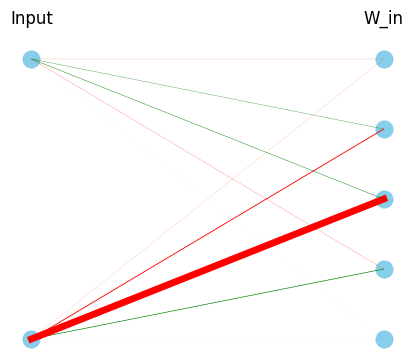

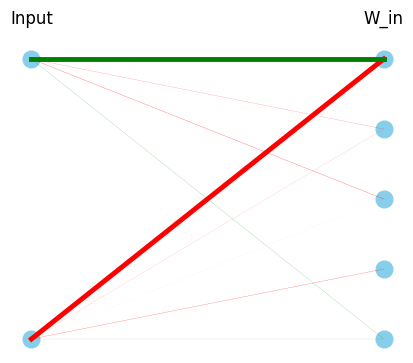

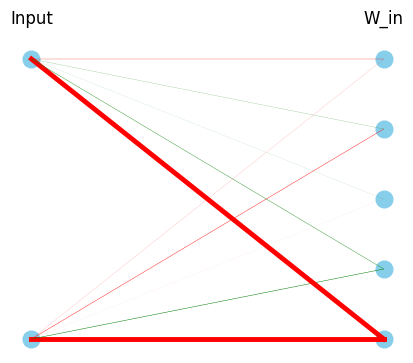

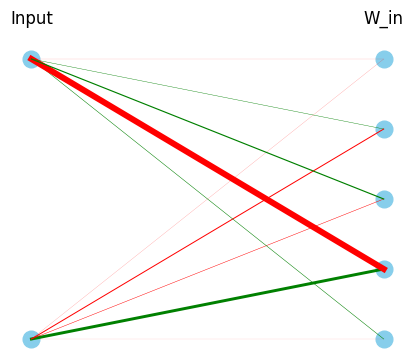

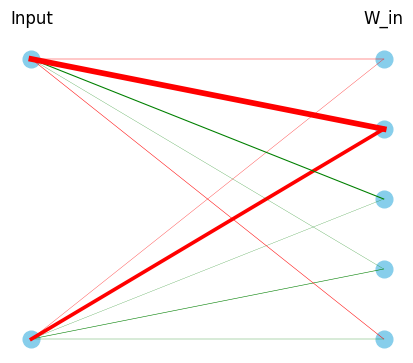

In [217]:
for u in [eigenmodel_tms.vector_to_parameters(u) for u in eigenmodel_tms.u]:
    DrawNeuralNetwork(u)

## TMS Parallel

In [ ]:
#@title Train Eigenmodel
n_u_vectors = 3 
batch_size = 32
lambda_penalty = [1,1]
n_epochs = 2
learning_rate = .01
u_batch_size = 20

torch.cuda.empty_cache()
gc.collect()

x_transformer_dataloader = DataLoader(X_transformer[::100], batch_size=batch_size, shuffle=True)


#t0 = time.time()
eigenmodel_transformer = EigenEstimation(transformer_model, 
                         custom_loss, n_u_vectors, u_chunk_size=20).to(device)


TrainEigenEstimation(
    eigenmodel_transformer,
    x_transformer_dataloader,
    lr=learning_rate,
    n_epochs= n_epochs,
    lambda_penalty=lambda_penalty,
    u_batch_size = u_batch_size,
    device = device
)

## 2L Transformer

In [98]:
#@title Train Eigenmodel
n_u_vectors = 3 
batch_size = 32
lambda_penalty = [1,1]
n_epochs = 2
learning_rate = .01
u_batch_size = 20

torch.cuda.empty_cache()
gc.collect()

x_transformer_dataloader = DataLoader(X_transformer[::100,:3], batch_size=1, shuffle=True)

torch.cuda.empty_cache()
gc.collect()

def custom_loss(x,y):
    print(x.shape)
    squared = x**2 * (x<1e-5).float()
    print(squared.shape)
    return squared

def M0(x):
    return torch.rand_like(transformer_model(x)).softmax(dim=-1)

eigenmodel_transformer = EigenEstimationComparison(transformer_model, M0,
                         KLDivergenceLoss(), 10).to(device)


TrainEigenEstimationComparison(eigenmodel_transformer, x_transformer_dataloader, learning_rate, n_epochs, lambda_penalty, device='cuda')


RuntimeError: einsum(): subscript a has size 8192 for operand 1 which does not broadcast with previously seen size 256

In [100]:
eigenmodel(X_transformer[:2,:2].to(device), eigenmodel.param_dict)

RuntimeError: einsum(): subscript a has size 2 for operand 1 which does not broadcast with previously seen size 15

In [97]:
KLDivergenceLoss()(
    transformer_model(X_transformer[:10]),
    M0(X_transformer[:10])).shape


torch.Size([10, 24])

In [ ]:
M0(x[:10])

In [4]:

def custom_loss(x,y):
    squared = x# * (x<1e-5).float()
    return squared

#t0 = time.time()
eigenmodel_transformer = EigenEstimation(transformer_model, 
                         custom_loss, n_u_vectors, u_chunk_size=20).to(device)


TrainEigenEstimation(
    eigenmodel_transformer,
    x_transformer_dataloader,
    lr=learning_rate,
    n_epochs= n_epochs,
    lambda_penalty=lambda_penalty,
    u_batch_size = u_batch_size,
    device = device
)

NameError: name 'u_dataloader' is not defined

In [92]:
from torch.func import jacrev, jacfwd, vjp
from functools import partial 
import time
from torch.autograd.functional import jacobian

def custom_loss(x,y):
        print(x.shape)
        return x#
        return sampled_elements

torch.cuda.empty_cache()
gc.collect()

#t0 = time.time()
eigenmodel_transformer = EigenEstimation(transformer_model, 
                         custom_loss, 100, u_chunk_size=20).to(device)




myfunc = partial(eigenmodel_transformer.compute_loss, X_transformer[:32,:])

with torch.no_grad():
        Ps = myfunc(eigenmodel_transformer.w0)
        Ps# * (x<1e-5).float()
        idx = torch.multinomial(flat.detach(), num_samples=1, replacement=False)
        row_indices = torch.arange(flat.size(0)).unsqueeze(1)  # Create row indices
        output = flat*0
        output[row_indices, idx] = 1/flat[row_indices, idx]






t = time.time()
with torch.no_grad():
   j = jacrev(myfunc)(eigenmodel_transformer.w0,)
   j_u = (j @ eigenmodel_transformer.u.transpose(0,1)).transpose(0,1)
   test = einops.einsum(j_u, j_u, '... u1, ... u2 -> ... u1 u2')
print(time.time()-t)
print(abs(test).sum())

torch.Size([32, 24, 50257])
torch.Size([32, 24, 50257])



KeyboardInterrupt



In [76]:
(_, vjpfunc) = torch.func.vjp(myfunc, x)
>>> cotangents = {'first': torch.ones([5]), 'second': torch.ones([5])}
vjps = vjpfunc(cotangents)

torch.Size([8192])

In [91]:

myfunc = partial(eigenmodel_transformer.compute_loss, X_transformer[:32,:])

with torch.no_grad():
        flat = myfunc(eigenmodel_transformer.w0).flatten(0,1)# * (x<1e-5).float()
        idx = torch.multinomial(flat.detach(), num_samples=3, replacement=False)
        row_indices = torch.arange(flat.size(0)).unsqueeze(1)  # Create row indices
        output = flat*0
        output[row_indices, idx] = 1/flat[row_indices, idx]


torch.Size([32, 24, 50257])


In [90]:
output

torch.Size([768, 50257])

In [22]:
j.shape

torch.Size([20, 3, 8192])

torch.Size([20, 3])

In [235]:

def custom_loss(x,y):
        #squared = x# * (x<1e-5).float()
        _, idx = x.topk(8, dim=-1)
        print(x[...,idx].shape)        
        #idx = (x>(1/x.shape[-1])).detach()
        return x[...,idx]

torch.cuda.empty_cache()
gc.collect()

#t0 = time.time()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [231]:
_, idx = test.topk(8, dim=-1)
test[...,idx].shape

torch.Size([20, 20, 8])

In [174]:
eigenmodel_transformer.u.transpose(0,1).shape

torch.Size([8192, 2])

In [172]:
test.shape

torch.Size([1234, 1234])

In [167]:
eigenmodel_transformer.u.shape

torch.Size([2, 8192])

In [165]:
test.shape

torch.Size([8192, 8192])

In [166]:
torch.cuda.empty_cache()
gc.collect()

for n,p in transformer_model.named_parameters(): print(n, p.numel())

print(
    abs(torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)
    ).max())
print((
    torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).min()
)
print(abs(
    2*torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).mean()
)

with torch.no_grad():
    for i in range(n_u_vectors):
        print(f'-----{i}-----')
        PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[1::100,:8], i,top_k=5, batch_size=24)


transformer.blocks.4.attn.W_Q 4096
transformer.blocks.4.attn.W_K 4096
tensor(0.0847, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>)
-----0-----


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 24 but got size 18 for tensor number 82 in the list.

In [198]:
P = transformer_model(X_transformer[0,:])
print((P>(1/P.shape[-1])).sum())
P[(P.detach()> (1/P.shape[-1]))].shape

tensor(8906, device='cuda:0')


torch.Size([8906])

np.float32(0.087245)

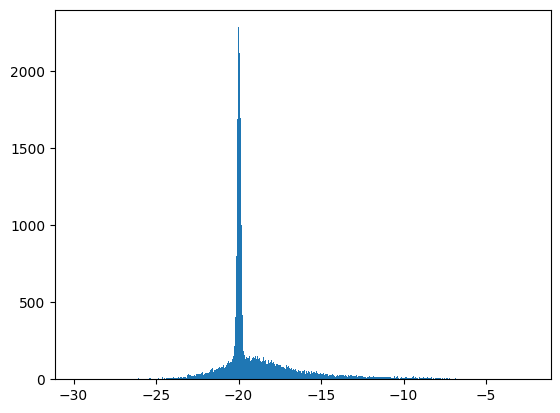

In [214]:
import numpy as np
a = P[0,4,:].detach().cpu().numpy()
a.shape
plt.hist(np.log(a), bins=1000)
max(a)

In [33]:
n_u_vectors

100

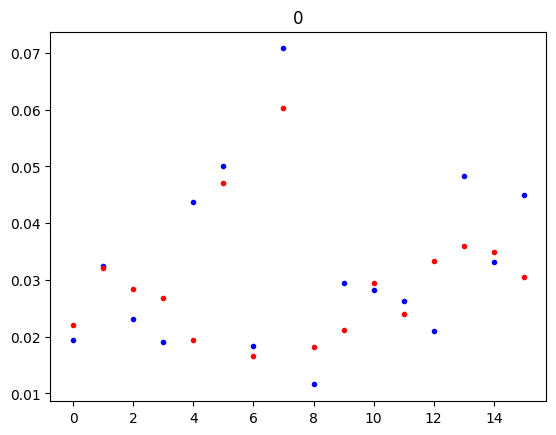

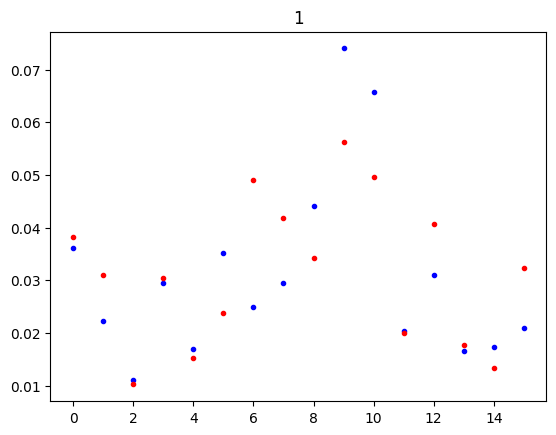

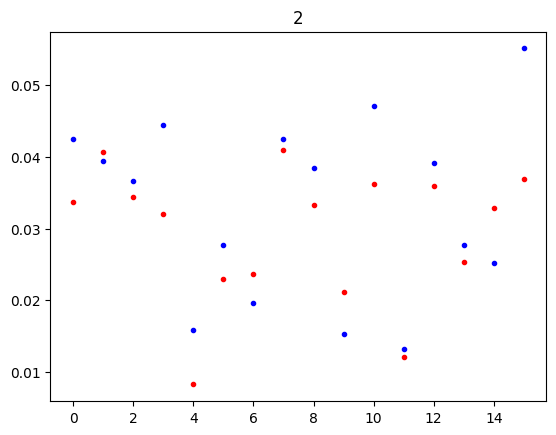

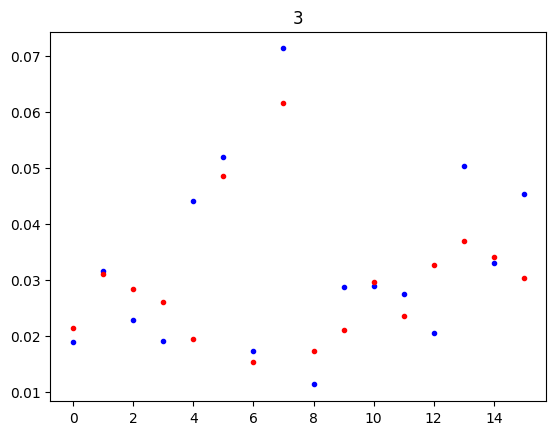

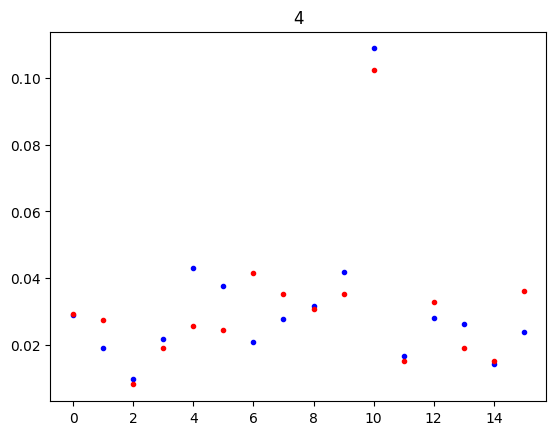

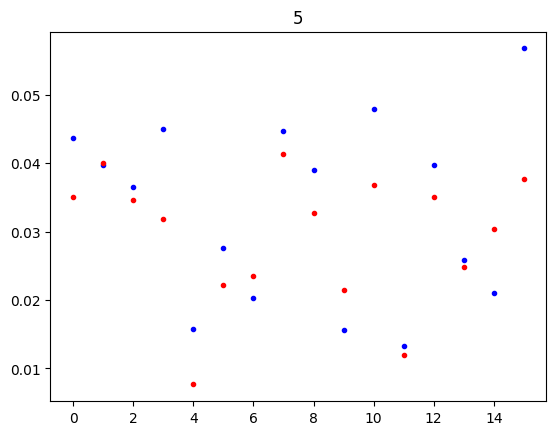

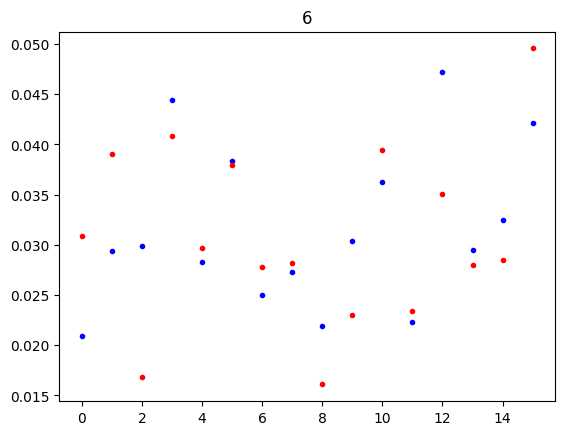

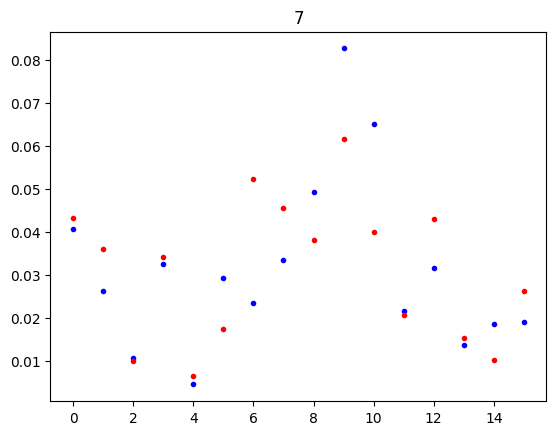

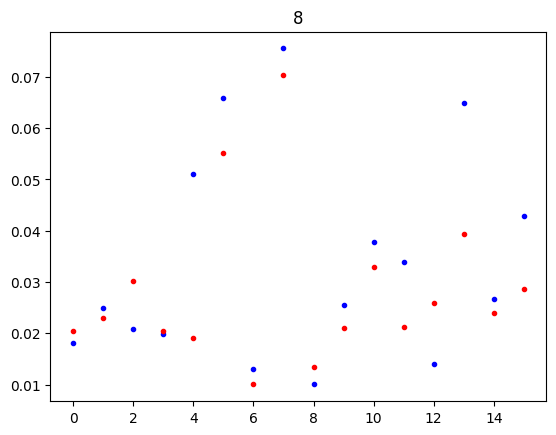

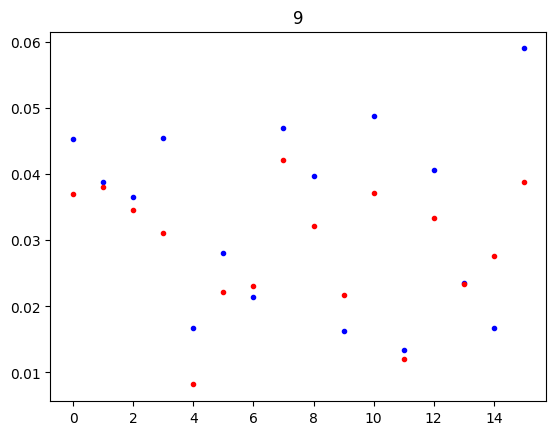

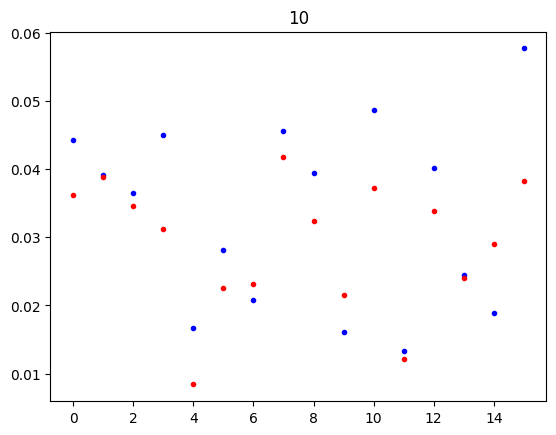

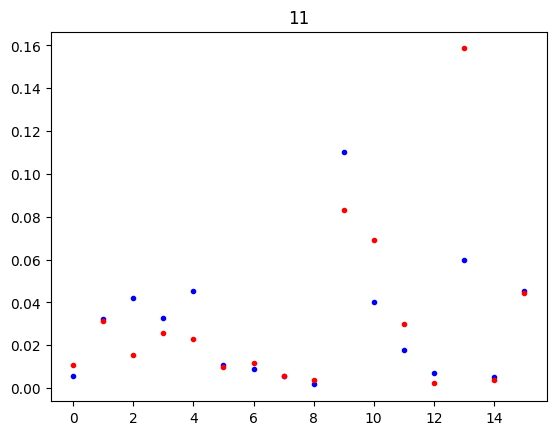

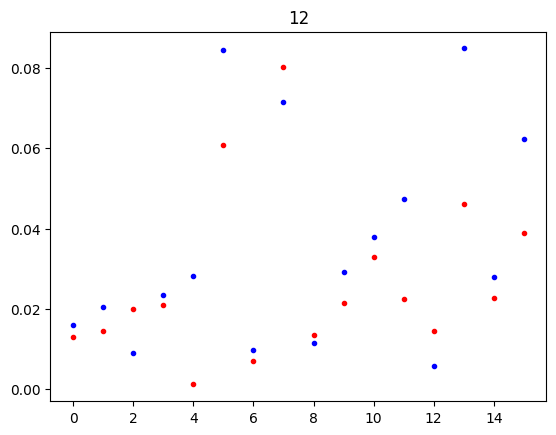

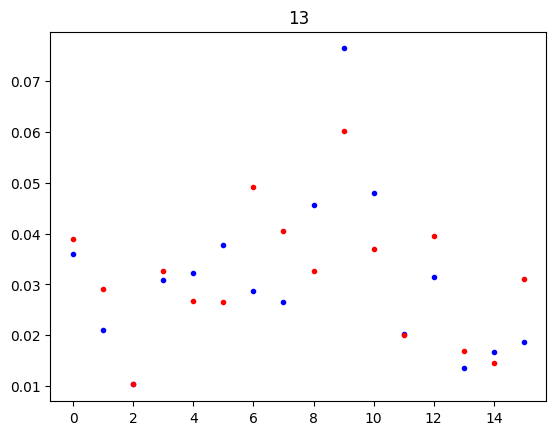

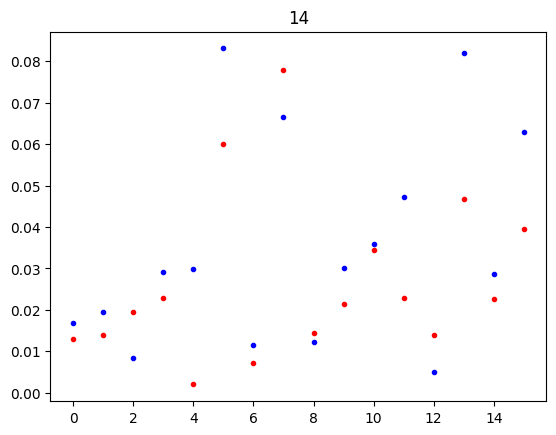

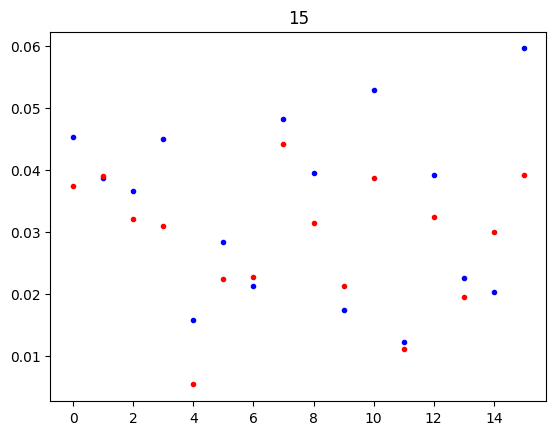

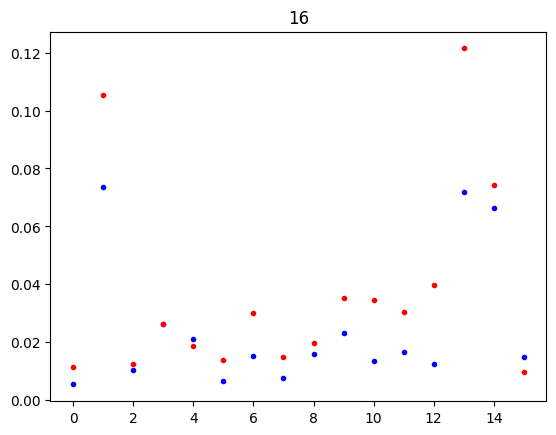

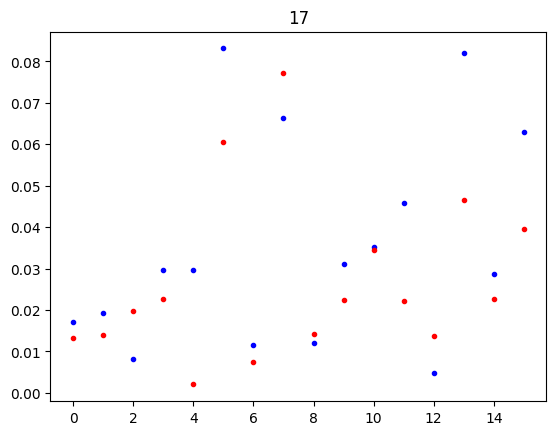

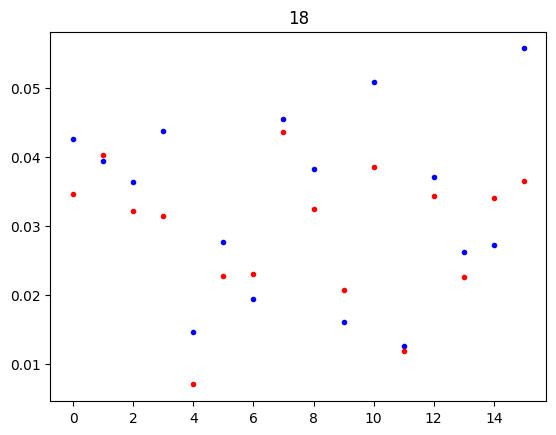

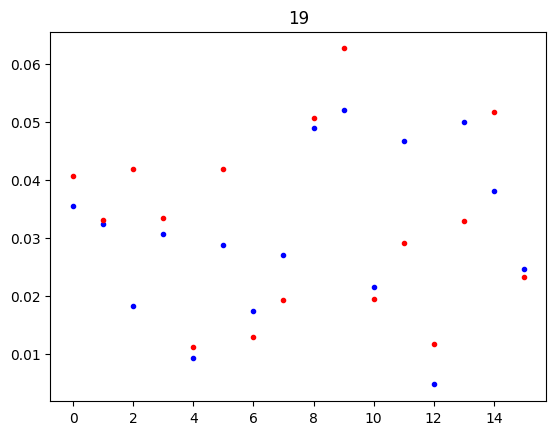

In [323]:
for f_idx in range(20):
    v1, v2 = [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][f_idx].values()
    plt.plot((v1**2).sum(dim=-1).sum(dim=-1).detach().cpu().numpy(), 'b.')
    plt.plot((v2**2).sum(dim=-1).sum(dim=-1).detach().cpu().numpy(), 'r.')#print(name, (vec**2).sum(dim=-1).sum(dim=-1))
    plt.title(f_idx)
    plt.show()

In [301]:
test = transformer_model.transformer
test.cfg

HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': -1.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': ['global',
                'local',
                'global',
                'local',
                'global',
                'local',
                'global',
                'local'],
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 4,
 'd_mlp': 256,
 'd_model': 64,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': np.float64(0.1),
 'load_in_4bit': False,
 'model_name': 'TinyStories-1M',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 16,
 'n_key_value_heads': None,
 'n_layers': 8,
 'n_pa

In [290]:
vec.shape

torch.Size([16, 64, 4])

In [252]:
torch.cuda.empty_cache()
gc.collect()

import numpy as np
for i in range(10):
    print([(v**2).sum(dim=0).sum(dim=0) for v in [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][i].values()])
    #a = [(v**2).sum().item() for v in [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][i].values()]
    #plt.plot(a, label=i)
    #plt.show()
    #plt.hist(eigenmodel_transformer.u[i].detach().cpu().numpy(), bins=100)
    #plt.show()
#plt.legend()
#plt.show()

[tensor([0.1428, 0.1338, 0.1355, 0.1078], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1244, 0.1247, 0.1137, 0.1172], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.0974, 0.1381, 0.1110, 0.1493], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1396, 0.1182, 0.1172, 0.1292], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1319, 0.1085, 0.1400, 0.1495], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1259, 0.1076, 0.1154, 0.1213], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1439, 0.1353, 0.1347, 0.1091], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1242, 0.1240, 0.1128, 0.1160], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1227, 0.1301, 0.1049, 0.1438], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1326, 0.1241, 0.1042, 0.1377], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1309, 0.1092, 0.1413, 0.1513], device='cuda:0',
       grad_fn=<SumBackward1>), tens

In [1]:
dH_du_tensor = eigenmodel_transformer(X_transformer[:32], eigenmodel_transformer.u).transpose(0,1)
#print(dH_du_tensor.shape)
u_tensor = eigenmodel_transformer.u
cosine_sims = u_tensor @ u_tensor.transpose(0,1)
prod = einops.einsum(dH_du_tensor, dH_du_tensor, 'k1 ... , k2 ...->... k1 k2')
print(prod.shape, cosine_sims.shape)
prod_cosin_sims = einops.einsum(prod, cosine_sims, '... k1 k2, k1 k2 ->... k1 k2')

NameError: name 'eigenmodel_transformer' is not defined

In [90]:
torch.cuda.empty_cache()
gc.collect()

def custom_loss(x,y):
    print(x.shape)
    squared = x**2 * (x<1e-5).float()
    print(squared.shape)
    return squared

def M0(x):
    return torch.rand_like(transformer_model(x)).softmax(dim=-1)

eigenmodel_transformer = EigenEstimationComparison(transformer_model, M0,
                         KLDivergenceLoss, 100, u_chunk_size=20).to(device)


TrainEigenEstimationComparison(eigenmodel_transformer, dataloader_trans, learning_rate, n_epochs, lambda_penalty, device='cuda')


In [52]:



def test(x, us):
    print('doing this!')
    return jvp(partial(eigenmodel_transformer.compute_loss, x), (eigenmodel_transformer.w0,), (us,))[1]


#test(X_transformer[:2,:2], eigenmodel_transformer.u[2])
import time
t= time.time()
#transformer_model(X_transformer[:10,:10])
#eigenmodel_transformer.compute_loss(X_transformer[:10,:8], eigenmodel_transformer.w0)
a = vmap(test, in_dims=(None, 0), out_dims=0, chunk_size=20)(X_transformer[:32], eigenmodel_transformer.u[:100])
print(a.shape)
result = einops.einsum(a, a, 'v batch tokens ps, v batch tokens ps -> v batch tokens')
jr = jacrev(eigenmodel_transformer.compute_loss, argnums=1, chunk_size=10)(
    X_transformer[:8], eigenmodel_transformer.w0,)
#jr = test(X_transformer[:48,:4], eigenmodel_transformer.u[1])
#print(a.shape,'here')
#result = einops.einsum(jr, eigenmodel_transformer.u, '... w, v w -> ... v')
#
# print(result.shape)
#test = einops.einsum(result, result,'v batch1 tokens1, v batch2 tokens2 -> batch1 batch2 tokens1 tokens2')
#diagonal = torch.diagonal(test, dim1=0, dim2=1)
#diagonal.zero_()
#test = test/result.shape[0]
#print(result.sum())
#print(test.sum())
#print(result)
print(time.time()-t)
#print(test)
#jvp(partial(eigenmodel_transformer.compute_loss, ), (eigenmodel_transformer.w0,), (eigenmodel_transformer.u[2],))[1].shape

doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
torch.Size([100, 32, 8, 50257])
0.5966215133666992


In [24]:
    from torch.func import jacrev, functional_call, jvp, vmap, jacrev
    torch.cuda.empty_cache()
    gc.collect()

    def compute_loss(
        x: torch.Tensor, parameters: torch.Tensor
    ) -> torch.Tensor:
        # Perform a stateless functional call to the model with given parameters
        param_dict = eigenmodel_transformer.vector_to_parameters(parameters)
        outputs: torch.Tensor = functional_call(eigenmodel_transformer.model, param_dict, (x,))
        # Detach outputs to prevent gradients flowing back
        with torch.no_grad():
            truth: torch.Tensor = eigenmodel_transformer.model(x,)

        # CrossEntropyLoss needs to be of form (_, n_classes, ...)        
        #outputs = einops.rearrange(outputs, '... c -> c ...').unsqueeze(0)
        #truth = einops.rearrange(truth, '... c -> c ...').unsqueeze(0)

        # Compute the loss without reduction
        return eigenmodel_transformer.loss(outputs[:2], truth[:2])#.squeeze(0)

    jr = jacrev(compute_loss, argnums=1, chunk_size=1000)(
        X_transformer[:10,:], eigenmodel_transformer.w0,)

In [16]:
eigenmodel_transformer.w0.shape

torch.Size([8192])

In [65]:
a.max()

tensor(8.9725e-08, device='cuda:0', grad_fn=<MaxBackward1>)

In [210]:
jvp(partial(eigenmodel_transformer.compute_loss, X_transformer[:10,:10]), (eigenmodel_transformer.w0,), (eigenmodel_transformer[:10,:10].u[1],))[1]

TypeError: 'EigenEstimation' object is not subscriptable

In [205]:
partial(eigenmodel_transformer.compute_loss, X_transformer[:10,:10]) (eigenmodel_transformer.w0,).shape

torch.Size([10, 8, 50257])

In [208]:
def test(x, us):
    print('doing this!')
    return jvp(partial(compute_loss, x), (eigenmodel_transformer.w0,), (us,))[1]

def func(w):
    partial(eigenmodel_transformer.compute_loss, x) (eigenmodel_transformer.w0,)

torch.autograd.functional.jacobian(
    partial(eigenmodel_transformer.compute_loss,
    X_transformer[:10,:10]), (eigenmodel_transformer.w0,), create_graph=False, vectorize=True,strategy='forward-mode')

OutOfMemoryError: CUDA out of memory. Tried to allocate 61.35 GiB. GPU 0 has a total capacity of 39.38 GiB of which 10.07 GiB is free. Including non-PyTorch memory, this process has 29.30 GiB memory in use. Of the allocated memory 16.49 GiB is allocated by PyTorch, and 12.32 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [194]:
jr.shape

torch.Size([3, 2, 50257, 4096])

In [185]:
eigenmodel_transformer.w0.requires_grad_(True)
A = eigenmodel_transformer.compute_loss(X_transformer[:10], eigenmodel_transformer.w0)
print(A.flatten())
eigenmodel_transformer.w0.requires_grad_(True)
jvp = torch.autograd.grad(A.flatten(), eigenmodel_transformer.w0)#, grad_outputs=eigenmodel_transformer.u[:2], retain_graph=False)


tensor([1.0469, 2.6363, 1.3793, 3.5012, 1.8782, 1.8265, 1.3879, 1.0285, 1.7043,
        2.3596], device='cuda:0', grad_fn=<SumBackward1>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
torch.autograd.grad(vjp_flat, u, grad_outputs=v, retain_graph=False)

In [12]:
transformer_model(X_transformer[:32,:24]).shape

torch.Size([32, 8, 50257])

In [11]:
X_transformer[:32,:24]

tensor([[32565,    13, 15899,  2497,   262, 22441,  1097,   290],
        [  531,    11,   366, 22017,    11, 21168,    11,   534],
        [ 1097,   318,   523,  6016,   290,  3424,  2474, 21168],
        [13541,   290,  8712,    11,   366, 10449,   345,    11],
        [15899,    13,   314, 25245,   340,   790,  1110,   526],
        [  198,   198,  3260,  2712,   351,   262,  1097,    11],
        [21168,   290, 15899,  2936, 47124,    13,  1119,  1043],
        [  257,  1402, 16723,   351,  1598,  1660,    13,  1119],
        [24070,   262,  1660,   290,  2936,   845,  3772,    13],
        [ 1119,  2826,  1978,   477,  1110,   290,  2627,  1266],
        [ 2460,    13, 50256,  7454,  2402,   257,   640,    11],
        [  287,   257,  1263,  8222,    11,   612,  5615,   257],
        [ 9529,   259,   420, 27498,  3706,   371, 23536,    13],
        [  371, 23536,  6151,   284, 12080,    13,  1375, 19952],
        [ 7150,    11, 12586,    11,   290, 18639,    13,  1881],
        [ 

tensor([[[-8.5894e+01, -2.3941e+00, -1.1500e+01,  ..., -7.6702e+00,
          -5.5782e+01, -1.2205e+01],
         [-9.6746e+00,  7.1325e+01, -3.6352e+01,  ...,  4.5261e+01,
          -2.3040e+01,  3.6567e+01],
         [-3.3833e+01,  2.7846e+01,  4.0171e+01,  ..., -4.3040e+01,
           1.4843e+02, -2.6281e+01],
         ...,
         [ 2.8213e+01, -5.1905e+00,  2.9090e+00,  ...,  2.5676e+00,
           2.8102e+01, -1.8393e+01],
         [-5.8760e+01,  1.9943e+02, -7.0192e+01,  ..., -1.1632e+02,
          -1.9838e+01,  7.7984e+01],
         [ 6.4258e+01, -1.3235e+02, -6.4691e-02,  ..., -2.0529e+02,
          -1.5658e+02, -9.6852e+01]],

        [[ 1.8510e+02, -9.0249e+01,  6.9382e+01,  ...,  2.7165e+01,
           7.3389e+01,  2.4455e+02],
         [-4.1367e+01,  3.2348e+01, -1.6189e+02,  ...,  1.6565e+02,
           3.2797e+01, -5.8197e+01],
         [-1.7341e+01, -2.0934e+01, -2.2331e+00,  ...,  1.8623e+01,
           4.6183e+01,  2.5598e+01],
         ...,
         [-1.4336e+02, -1

In [209]:
eigenmodel_transformer = EigenEstimation(transformer_model.to(device), 
                         lambda x,y: x[...,:15], 1000, u_chunk_size=20).to(device)

In [172]:
torch.cuda.empty_cache()
gc.collect()

0

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 GiB. GPU 0 has a total capacity of 39.38 GiB of which 11.99 GiB is free. Including non-PyTorch memory, this process has 27.38 GiB memory in use. Of the allocated memory 24.54 GiB is allocated by PyTorch, and 2.35 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [144]:
diagonal.shape

torch.Size([8, 8, 32])

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.3808e+10, 1.4676e+10, 5.9526e+10,  ..., 1.1504e+11,
           9.3946e+10, 2.9889e+10],
          [3.7045e+10, 2.0861e+10, 7.3973e+10,  ..., 1.3449e+11,
           1.2811e+11, 3.3928e+10],
          [8.7924e+10, 4.0123e+10, 1.4115e+11,  ..., 2.5739e+11,
           2.5404e+11, 7.7876e+10],
          ...,
          [5.8286e+10, 3.1464e+10, 9.4514e+10,  ..., 2.5262

In [105]:
torch.combinations(torch.arange(batch_size), r=2).shape

torch.Size([496, 2])

In [99]:
batch_size = tensor.size(0)
indices = torch.combinations(torch.arange(result.size(1)), r=2)

# Extract the elements where batch1 != batch2
selected_elements = torch.stack([tensor[i, j] for i, j in indices])


tensor([[[[4.0040e+10, 3.2041e+10, 6.4844e+10,  ..., 4.8275e+10,
           9.5809e+10, 1.1833e+11],
          [3.2041e+10, 7.3487e+10, 8.9767e+10,  ..., 7.3261e+10,
           1.4204e+11, 1.6520e+11],
          [6.4844e+10, 8.9767e+10, 3.3806e+11,  ..., 1.2906e+11,
           2.5000e+11, 2.9890e+11],
          ...,
          [4.8275e+10, 7.3261e+10, 1.2906e+11,  ..., 1.7535e+11,
           1.8264e+11, 2.1204e+11],
          [9.5809e+10, 1.4204e+11, 2.5000e+11,  ..., 1.8264e+11,
           1.2541e+12, 5.7197e+11],
          [1.1833e+11, 1.6520e+11, 2.9890e+11,  ..., 2.1204e+11,
           5.7197e+11, 1.0471e+12]],

         [[3.3808e+10, 1.4676e+10, 5.9526e+10,  ..., 1.1504e+11,
           9.3946e+10, 2.9889e+10],
          [3.7045e+10, 2.0861e+10, 7.3973e+10,  ..., 1.3449e+11,
           1.2811e+11, 3.3928e+10],
          [8.7924e+10, 4.0123e+10, 1.4115e+11,  ..., 2.5739e+11,
           2.5404e+11, 7.7876e+10],
          ...,
          [5.8286e+10, 3.1464e+10, 9.4514e+10,  ..., 2.5262

In [116]:
torch.cuda.empty_cache()
gc.collect()
#for n, p in eigenmodel_transformer.model.named_parameters(): print(n, p.numel())
#print('\n')
for i in list(range(min(10,eigenmodel_transformer.n_u_vectors))):
  print(i)
  PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[:100], i, 5, 64, device)
  print('\n')

0
 Kitty and** Spot** felt thirsty. They found ->  Spot (Value: 63482.133)
,** Sue**, for being so thoughtful and ->  Sue (Value: 41138.707)
 a name. Her** name** was Daisy. ->  name (Value: 41049.613)
 careful."** Sue** felt proud that she could ->  Sue (Value: 39540.402)
 His** name** was Max. Max liked to ->  name (Value: 35068.254)


1
?" Her mom said,** "**Yes, ->  " (Value: 252338.953)
 smiled and replied,** "**Thank you, ->  " (Value: 165065.750)
 said,** "**Wow, Kitty, your ->  " (Value: 86251.016)
 it. Billy said,** "**I have ->  " (Value: 67452.812)
 mom, so she said,** "**Mom ->  " (Value: 61045.062)


2
, Sue, for being so thoughtful** and** ->  and (Value: 54741.414)
 Kitty** and** Spot felt thirsty. They found ->  and (Value: 17642.449)
 help from a friend**,** she could climb -> , (Value: 16558.445)
 car is so bright** and** clean!" Kitty ->  and (Value: 16394.727)
 Roxy was sad** and** asked, " ->  and (Value: 12962.355)


3
, Sue, for being so thoughtful** and** ->  an